# Фаза 2 • Неделя 2 • Понедельник
## Компьютерное зрение
### Локализация объектов

#### Подготовим импорты

Из нового: 
1. `xml.etree.ElementTree` – с помощью него будем разбирать XML-файлы и доставать координаты bbox'ов 
2. `torchmetrics.functional.detection.iou` – чтобы вручную не считать IoU

In [22]:
import os
import xml.etree.ElementTree as ET
from glob import glob
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchutils as tu
import torchvision.transforms as T
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection.iou import intersection_over_union
from torchvision.models import ResNet18_Weights, resnet18, ResNet152_Weights, resnet152

import mplcyberpunk
plt.style.use("cyberpunk")

#### XML-файлы

In [2]:
annotation = ET.parse('data/Veg/loc_train/cucumber_1.xml')

In [3]:
print(annotation)

In [4]:
annotation.find('object').find('bndbox').find('xmax').text

'206'

#### Подгтовим датасет

Он принимает на вход в конструктор 3 переменные: 
* `root_dir` – путь к обучающим/валидационным файлам (включая соответствующие xml-файлы)
* `image_size` – сразу определимся с размером картинок (у нас 227х227)
* `transform` – какие преобразования использовать для картинок (как минимум `ToTensor`, но обучающие будем аугментировать)

In [29]:
class CustomDataset(Dataset):
    def __init__(
            self, 
            root_dir: str, 
            image_size: int = 227, 
            transform: T.Compose = None
            ):
        self.image_size = image_size
        self.root_dir = root_dir
        self.transform = transform
        # создаем два списка: с картинками и xml
        self.img_paths = sorted(glob(f'{self.root_dir}/*.jpg'))
        self.xml_paths = sorted(glob(f'{self.root_dir}/*.xml'))

        # делаем вспомогательные словари, чтобы из названий классов получать индексы
        self.cls2ix = {
            'cucumber' : 0, 
            'eggplant' : 1, 
            'mushroom' : 2
            }
        # и наоборот
        self.ix2cls = {v: k for k, v in self.cls2ix.items()}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # по индексу находим в списке файлов аннотацию
        annotation = ET.parse(self.xml_paths[idx]) 
        # забираем название файла с картинкой
        filename = annotation.find('filename').text
        # открываем картинку
        image = Image.open(os.path.join(self.root_dir, filename))
        # преобразуем
        if self.transform:
            image = self.transform(image)
        # получаем название класса
        label = annotation.find('object').find('name').text
        # преобразуем в индекс
        label = self.cls2ix[label]
        # получаем координаты настоящего бокса
        xmin = int(annotation.find('object').find('bndbox').find('xmin').text)
        ymin = int(annotation.find('object').find('bndbox').find('ymin').text)
        xmax = int(annotation.find('object').find('bndbox').find('xmax').text)
        ymax = int(annotation.find('object').find('bndbox').find('ymax').text)
        # конвертируем в тензор и масштабируем в диапазон [0-1]
        bbox = torch.Tensor((xmin, ymin, xmax, ymax)) / self.image_size
        return torch.tensor(label), bbox, image, filename

In [30]:
train_aug = T.Compose(
    [   
        
        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.3, 5.)),
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
valid_aug = T.Compose(
    [   
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
train_dataset = CustomDataset(root_dir='data/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='data/Veg/loc_valid', image_size=227, transform=valid_aug)


In [31]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
batch = next(iter(train_loader))
batch

[tensor([1, 1, 2, 2, 0, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 0,
         0, 2, 0, 2, 1, 0, 1, 2]),
 tensor([[0.1542, 0.1630, 0.9075, 0.6828],
         [0.2247, 0.2159, 0.8811, 0.8722],
         [0.1057, 0.2026, 0.9031, 0.9339],
         [0.1894, 0.0881, 0.8678, 0.8018],
         [0.1057, 0.3612, 0.8987, 0.6784],
         [0.1057, 0.1145, 0.8811, 0.8678],
         [0.1586, 0.0485, 0.9471, 0.9119],
         [0.0485, 0.4361, 0.6211, 0.7797],
         [0.1101, 0.2952, 0.8855, 0.7181],
         [0.0396, 0.0485, 0.9824, 0.9559],
         [0.1498, 0.1498, 0.3877, 0.8855],
         [0.1410, 0.1542, 0.8414, 0.8678],
         [0.4934, 0.2423, 0.8943, 0.8150],
         [0.2423, 0.1322, 0.7357, 0.9339],
         [0.0485, 0.1366, 0.9559, 0.9163],
         [0.0352, 0.0044, 0.9912, 0.9736],
         [0.1498, 0.1366, 0.8282, 0.8855],
         [0.0661, 0.2467, 0.9339, 0.6872],
         [0.0573, 0.5683, 0.8634, 0.7489],
         [0.1762, 0.3084, 0.7885, 0.7401],
         [0.3392, 0.0837

# Модель 

В качестве экстрактора признаков будем использовать предобученный ResNet18, но отрежем последние два слоя: пулинг и полносвязный

In [33]:
feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
feature_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)

feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])

In [35]:
feature_extractor(torch.randn(1, 3, 227, 227)).shape

torch.Size([1, 512, 8, 8])

Задаем класс модели в соответствии со схемой: 
<img src="../slides/sources/aux/localization_model.png">

In [112]:
class LocModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        # фризим слои, обучать их не будем (хотя технически можно)
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

        # задай классификационный блок
        self.clf = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.Sigmoid(),
            nn.Linear(128, 3)
        )

        # задай регрессионный блок
        self.box = nn.Sequential(
            nn.Linear(512*8*8, 128),
            nn.Sigmoid(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, img):
        # задай прямой проход
        resnet_out = self.feature_extractor(img)
        resnet_out = resnet_out.view(resnet_out.size(0), -1)
        pred_classes = self.clf(resnet_out)
        pred_boxes = self.box(resnet_out)
        # print(pred_classes.shape, pred_boxes.shape)
        return pred_classes, pred_boxes

In [39]:
model = LocModel()
model(torch.randn(1, 3, 227, 227))[1].squeeze(-1)

torch.Size([1, 3]) torch.Size([1, 4])


tensor([[0.5812, 0.5789, 0.4870, 0.5869]], grad_fn=<SqueezeBackward1>)

In [40]:
model(torch.randn(1, 3, 227, 227))[1]

torch.Size([1, 3]) torch.Size([1, 4])


tensor([[0.5357, 0.5036, 0.4449, 0.6027]], grad_fn=<SigmoidBackward0>)

In [48]:
model = LocModel()
# проверь модель на батче: помни, что он возвращает tuple, оттуда нужно не всё
tu.get_model_summary(model, torch.randn(1, 3, 227, 227))

torch.Size([1, 3]) torch.Size([1, 4])
Layer                                                    Kernel             Output          Params           FLOPs
0_feature_extractor.Conv2d_0                           [3, 64, 7, 7]   [1, 64, 114, 114]       9,408   122,266,368
1_feature_extractor.BatchNorm2d_1                               [64]   [1, 64, 114, 114]         128     3,326,976
2_feature_extractor.ReLU_2                                         -   [1, 64, 114, 114]           0             0
3_feature_extractor.MaxPool2d_3                                    -     [1, 64, 57, 57]           0             0
4_feature_extractor.4.0.Conv2d_conv1                  [64, 64, 3, 3]     [1, 64, 57, 57]      36,864   119,771,136
5_feature_extractor.4.0.BatchNorm2d_bn1                         [64]     [1, 64, 57, 57]         128       831,744
6_feature_extractor.4.0.ReLU_relu                                  -     [1, 64, 57, 57]           0             0
7_feature_extractor.4.0.Conv2d_conv2      

#### Обучение

In [49]:
# этот блок можно оставить, а можно изменить и посмотреть на результат
clf_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=.9)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25])

In [50]:
# создаем словарь для логов, 10 ключей (см. слайды)
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_reg_loss'] = []
log['epoch_valid_reg_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []

In [51]:
device = 'cuda'
model.to(device);

torch.Size([32, 3]) torch.Size([32, 4])


/tmp/ipykernel_20430/1634560269.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))


torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])


/tmp/ipykernel_20430/1634560269.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))


torch.Size([6, 3]) torch.Size([6, 4])
Epoch: 0  total_loss_train: 0.723, total_loss_valid: 0.472
	   train_clf_loss: 0.703, valid_clf_loss: 0.461
	   train_reg_loss: 0.020, valid_reg_loss: 0.011
	   train_clf_acc: 0.713, valid_clf_acc: 0.969
	   box_iou_train: 0.344, box_iou_valid: 0.423
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) torch.Size([20, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([6, 3]) torch.Size([6, 4])
Epoch: 1  total_loss_train: 0.284, total_loss_valid: 0.887
	   train_clf_loss: 0.275, valid_clf_loss: 0.880
	   train_reg_loss: 0.009, valid_reg_loss: 0.006
	   train_clf_acc: 0.994, valid_clf_acc: 0.630
	   box_iou_train: 0.481, box_iou_valid: 0.545
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([32, 3]) torch.Size([32, 4])
torch.Size([20, 3]) to

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


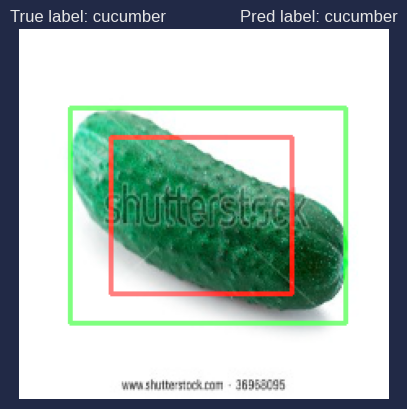

In [53]:
for i in range(100):
    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ####### обучающий шаг
    model.train()
    for true_label, true_box, image, filename  in train_loader:
        true_label = true_label.to(device)
        true_box = true_box.to(device)
        image = image.to(device)
        # filename = filename.to(device)
        preds_cls, preds_reg = model(image)
        
        loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
        batch_clf_loss.append(loss_cls.item())

        accuracy = ((preds_cls.argmax(axis=1) == true_label).cpu().numpy().mean())
        batch_acc.append(accuracy)

        loss_reg = F.huber_loss(preds_reg, true_box)
        batch_reg_loss.append(loss_reg.item())

        iou = intersection_over_union(preds_reg, true_box).mean().item()
        batch_iou.append(iou)

        loss = loss_cls + loss_reg
        batch_total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))

    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ######### валидационный шаг
    model.eval()
    for true_label, true_box, image, filename  in valid_loader:
        true_label = true_label.to(device)
        true_box = true_box.to(device)
        image = image.to(device)
        # filename = filename.to(device)
        with torch.no_grad():
            preds_cls, preds_reg = model(image)
            loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
            batch_clf_loss.append(loss_cls.item())

            accuracy = ((preds_cls.argmax(axis=1) == true_label).cpu().numpy().mean())
            batch_acc.append(accuracy)

            loss_reg = F.huber_loss(preds_reg, true_box)
            batch_reg_loss.append(loss_reg.item())

            iou = intersection_over_union(preds_reg, true_box).mean().item()  
            batch_iou.append(iou)

            loss = loss_cls + loss_reg
            batch_total_loss.append(loss.item())
            lr_scheduler.step()


    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))

    print(f"Epoch: {i}  total_loss_train: {log['epoch_train_total_loss'][-1]:.3f}, total_loss_valid: {log['epoch_valid_total_loss'][-1]:.3f}")
    print(f"\t   train_clf_loss: {log['epoch_train_clf_loss'][-1]:.3f}, valid_clf_loss: {log['epoch_valid_clf_loss'][-1]:.3f}")
    print(f"\t   train_reg_loss: {log['epoch_train_reg_loss'][-1]:.3f}, valid_reg_loss: {log['epoch_valid_reg_loss'][-1]:.3f}")
    print(f"\t   train_clf_acc: {log['epoch_train_accuracy'][-1]:.3f}, valid_clf_acc: {log['epoch_valid_accuracy'][-1]:.3f}")
    print(f"\t   box_iou_train: {log['epoch_train_iou'][-1]:.3f}, box_iou_valid: {log['epoch_valid_iou'][-1]:.3f}")


    # реализуй визуализацию: рандомная картинка из батча, настоящая рамка, предсказанная рамка. Используй cv2.Rectangle
model.eval()
with torch.no_grad():
    true_label, true_box, image, filename = next(iter(valid_loader))
    true_label = true_label.to(device)
    true_box = true_box.to(device)
    image = image.to(device)
    preds_cls, preds_reg = model(image)

    rnd_index = random.randint(0, preds_cls.size(0) - 1)
    img = image[rnd_index].permute(1, 2, 0).cpu().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # true box coordinates
    true_box_coords = (true_box[rnd_index] * train_dataset.image_size).cpu().numpy().astype('int')
    true_box_img = cv2.rectangle(
        img.copy(),
        (true_box_coords[0], true_box_coords[1]), # top left
        (true_box_coords[2], true_box_coords[3]), # bottom right
        color=(0, 255, 0), thickness=2
    )

    # predicted box coordinates
    pred_box_coords = (preds_reg[rnd_index] * train_dataset.image_size).cpu().detach().numpy().astype('int')
    pred_box_img = cv2.rectangle(
        img.copy(),
        (pred_box_coords[0], pred_box_coords[1]), # top left
        (pred_box_coords[2], pred_box_coords[3]), # bottom right
        color=(255, 0, 0), thickness=2
    )

    # combine true and predicted boxes on the same image
    combined_img = cv2.addWeighted(true_box_img, 0.5, pred_box_img, 0.5, 0)

    # plot the image with true and predicted boxes
    fig, ax = plt.subplots(1, 1, squeeze=True)
    ax.imshow(combined_img)
    ax.set_axis_off()
    plt.title(f'True label: {train_dataset.ix2cls[true_label[rnd_index].item()]} \
               Pred label: {train_dataset.ix2cls[preds_cls[rnd_index].argmax().item()]}')
    plt.show()

Визуализируй лоссы и метрики обучени на с помощью кривых обучения. Качество классифкации будет высоким, а вот IoU должен быть в интервале 0.5-0.6 – это слабая модель. 

In [126]:
def plot_history(log, grid=True):
    fig, ax = plt.subplots(5,1, figsize=(14,30))
    ax[0].plot(log['epoch_train_total_loss'], label='train total loss')
    ax[0].plot(log['epoch_valid_total_loss'], label='valid total loss')
    ax[0].set_title(f"Total loss on epoch {len(log['epoch_train_total_loss'])}")
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(log['epoch_train_clf_loss'], label='train loss')
    ax[1].plot(log['epoch_valid_clf_loss'], label='valid loss')
    ax[1].set_title(f"Classification loss on epoch {len(log['epoch_train_total_loss'])}")
    ax[1].grid(grid)
    ax[1].legend()

    ax[2].plot(log['epoch_train_reg_loss'], label='train loss')
    ax[2].plot(log['epoch_valid_reg_loss'], label='valid loss')
    ax[2].set_title(f"Regression bbox loss on epoch {len(log['epoch_train_total_loss'])}")
    ax[2].grid(grid)
    ax[2].legend() 

    ax[3].plot(log['epoch_train_accuracy'], label='train accuracy')
    ax[3].plot(log['epoch_valid_accuracy'], label='valid accuracy')
    ax[3].set_title(f"Classification accuracy on epoch {len(log['epoch_train_total_loss'])}")
    ax[3].grid(grid)
    ax[3].legend()

    ax[4].plot(log['epoch_train_iou'], label='train iou')
    ax[4].plot(log['epoch_valid_iou'], label='valid iou')
    ax[4].set_title(f"IoU on epoch {len(log['epoch_train_total_loss'])}")
    ax[4].grid(grid)
    ax[4].legend()

    plt.show()

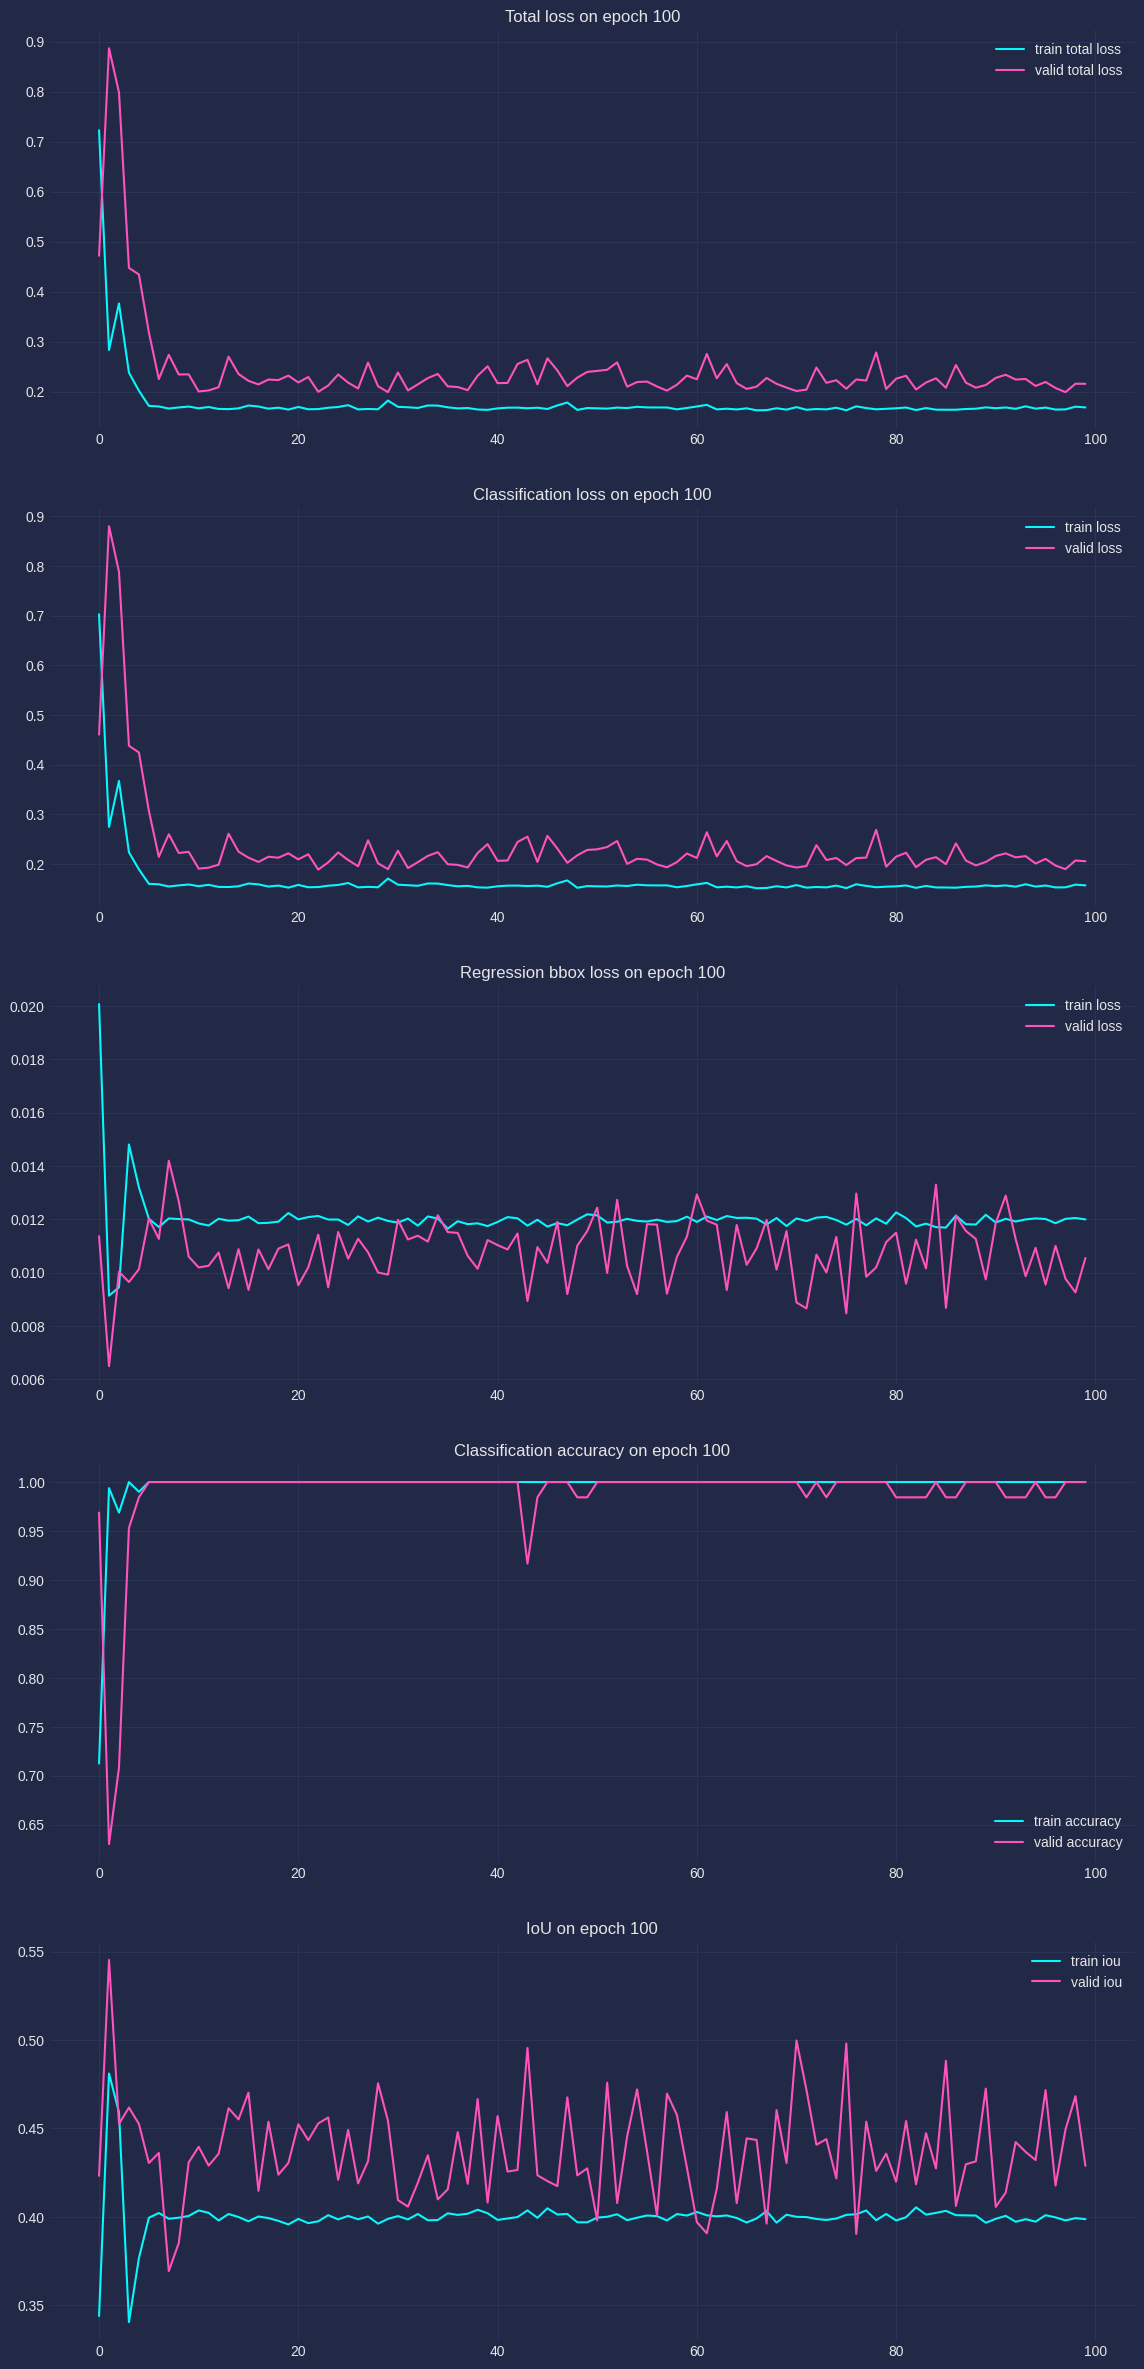

In [55]:
plot_history(log)

In [ ]:
fig, ax = plt.subplots(1, 1, squeeze=True)

    # возьмем случайную картинку из батча
    rnd_index = logits.size(0)-1
    img = image[rnd_index].permute(1, 2, 0).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    true_box = cv2.rectangle(
        img, 
        (true_box[rnd_index][:2].numpy()*train_dataset.image_size).astype('int'), # top left
        (true_box[rnd_index][2:].numpy()*train_dataset.image_size).astype('int'), # bottom right
        color=(0, 255, 0), thickness=2
        )
    pred_box = cv2.rectangle(
        img, 
        (coords[rnd_index][:2]*train_dataset.image_size).numpy().astype('int'), # top left
        (coords[rnd_index][2:]*train_dataset.image_size).numpy().astype('int'), # bottom right
        color=(255, 0, 0), thickness=2
        )
#     # print(coords[:2])
    ax.imshow(true_box)
    ax.imshow(pred_box)
    ax.set_axis_off()
    plt.title(f'True label: {train_dataset.ix2cls[true_label[rnd_index].item()]}\
                pred label: {train_dataset.ix2cls[logits[rnd_index].argmax().item()]}')
    plt.show()

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pred_box = cv2.rectangle(
        img, 
        (preds_reg[rnd_index][:2]*train_dataset.image_size).numpy().astype('int'), # top left
        (preds_reg[rnd_index][2:]*train_dataset.image_size).numpy().astype('int'), # bottom right
        color=(255, 0, 0), thickness=2
        )

ax.imshow(pred_box)
    ax.set_axis_off()
    plt.title(f'Pred label: {ix2cls[pred_class].argmax().item()]}')
    plt.show()

# Попытки улучшить

## 1 - ResNet152 и разморозка слоя layer4

In [90]:
train_aug = T.Compose(
    [   
        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.3, 5.)),
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
valid_aug = T.Compose(
    [   
        T.Resize((227, 227)),
        T.ToTensor()
    ]
)
train_dataset = CustomDataset(root_dir='data/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='data/Veg/loc_valid', image_size=227, transform=valid_aug)

In [91]:
feature_extractor = resnet152(weights=ResNet152_Weights.DEFAULT)
feature_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [92]:
for param in feature_extractor.parameters():
    param.requires_grad = False

In [93]:
for param in feature_extractor.layer4.parameters():
    param.requires_grad = True

In [94]:
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-2])

In [95]:
feature_extractor(torch.randn(1, 3, 227, 227)).shape

torch.Size([1, 2048, 8, 8])

In [79]:
for param in feature_extractor.parameters():
    print (param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [96]:
class NewModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = resnet152(weights=ResNet152_Weights.DEFAULT)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        for param in self.feature_extractor.layer4.parameters():
            param.requires_grad = True
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        # фризим слои, обучать их не будем (хотя технически можно)


        # задай классификационный блок
        self.clf = nn.Sequential(
            nn.Linear(2048*8*8, 128),
            nn.Sigmoid(),
            nn.Linear(128, 3)
        )

        # задай регрессионный блок
        self.box = nn.Sequential(
            nn.Linear(2048*8*8, 128),
            nn.Sigmoid(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, img):
        # задай прямой проход
        resnet_out = self.feature_extractor(img)
        resnet_out = resnet_out.view(resnet_out.size(0), -1)
        pred_classes = self.clf(resnet_out)
        pred_boxes = self.box(resnet_out)
        # print(pred_classes.shape, pred_boxes.shape)
        return pred_classes, pred_boxes

In [97]:
model = NewModel()
# model.to(device)

In [98]:
for param in model.parameters():
    print (param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [99]:
tu.get_model_summary(model, torch.randn(1, 3, 227, 227))

Layer                                                      Kernel              Output           Params           FLOPs
0_feature_extractor.Conv2d_0                              [3, 64, 7, 7]   [1, 64, 114, 114]        9,408   122,266,368
1_feature_extractor.BatchNorm2d_1                                  [64]   [1, 64, 114, 114]          128     3,326,976
2_feature_extractor.ReLU_2                                            -   [1, 64, 114, 114]            0             0
3_feature_extractor.MaxPool2d_3                                       -     [1, 64, 57, 57]            0             0
4_feature_extractor.4.0.Conv2d_conv1                     [64, 64, 1, 1]     [1, 64, 57, 57]        4,096    13,307,904
5_feature_extractor.4.0.BatchNorm2d_bn1                            [64]     [1, 64, 57, 57]          128       831,744
6_feature_extractor.4.0.ReLU_relu                                     -     [1, 64, 57, 57]            0             0
7_feature_extractor.4.0.Conv2d_conv2            

In [100]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=.6)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25])

In [101]:
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_reg_loss'] = []
log['epoch_valid_reg_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []

In [102]:
model.to(device)

NewModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [111]:
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_reg_loss'] = []
log['epoch_valid_reg_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []

for i in range(100):
    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ####### обучающий шаг
    model.train()
    for true_label, true_box, image, filename  in train_loader:
        true_label = true_label.to(device)
        true_box = true_box.to(device)
        image = image.to(device)
        # filename = filename.to(device)
        preds_cls, preds_reg = model(image)
        
        loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
        batch_clf_loss.append(loss_cls.item())

        accuracy = ((preds_cls.argmax(axis=1) == true_label).cpu().numpy().mean())
        batch_acc.append(accuracy)

        loss_reg = F.huber_loss(preds_reg, true_box, reduction='sum', delta=.6)
        batch_reg_loss.append(loss_reg.item())

        iou = intersection_over_union(preds_reg, true_box).mean().item()
        batch_iou.append(iou)

        loss = loss_cls + loss_reg
        batch_total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))

    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ######### валидационный шаг
    model.eval()
    for true_label, true_box, image, filename  in valid_loader:
        true_label = true_label.to(device)
        true_box = true_box.to(device)
        image = image.to(device)
        # filename = filename.to(device)
        with torch.inference_mode():
            preds_cls, preds_reg = model(image)
        loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
        batch_clf_loss.append(loss_cls.item())

        accuracy = ((preds_cls.argmax(axis=1) == true_label).cpu().numpy().mean())
        batch_acc.append(accuracy)

        loss_reg = F.huber_loss(preds_reg, true_box)
        batch_reg_loss.append(loss_reg.item())

        iou = intersection_over_union(preds_reg, true_box).mean().item()  
        batch_iou.append(iou)

        loss = loss_cls + loss_reg
        batch_total_loss.append(loss.item())
        lr_scheduler.step()


    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))

    print(f"Epoch: {i}  total_loss_train: {log['epoch_train_total_loss'][-1]:.3f}, total_loss_valid: {log['epoch_valid_total_loss'][-1]:.3f}")
    print(f"\t   train_clf_loss: {log['epoch_train_clf_loss'][-1]:.3f}, valid_clf_loss: {log['epoch_valid_clf_loss'][-1]:.3f}")
    print(f"\t   train_reg_loss: {log['epoch_train_reg_loss'][-1]:.3f}, valid_reg_loss: {log['epoch_valid_reg_loss'][-1]:.3f}")
    print(f"\t   train_clf_acc: {log['epoch_train_accuracy'][-1]:.3f}, valid_clf_acc: {log['epoch_valid_accuracy'][-1]:.3f}")
    print(f"\t   box_iou_train: {log['epoch_train_iou'][-1]:.3f}, box_iou_valid: {log['epoch_valid_iou'][-1]:.3f}")


    # реализуй визуализацию: рандомная картинка из батча, настоящая рамка, предсказанная рамка. Используй cv2.Rectangle
model.eval()
with torch.no_grad():
    true_label, true_box, image, filename = next(iter(valid_loader))
    true_label = true_label.to(device)
    true_box = true_box.to(device)
    image = image.to(device)
    preds_cls, preds_reg = model(image)

    rnd_index = random.randint(0, preds_cls.size(0) - 1)
    img = image[rnd_index].permute(1, 2, 0).cpu().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # true box coordinates
    true_box_coords = (true_box[rnd_index] * train_dataset.image_size).cpu().numpy().astype('int')
    true_box_img = cv2.rectangle(
        img.copy(),
        (true_box_coords[0], true_box_coords[1]), # top left
        (true_box_coords[2], true_box_coords[3]), # bottom right
        color=(0, 255, 0), thickness=2
    )

    # predicted box coordinates
    pred_box_coords = (preds_reg[rnd_index] * train_dataset.image_size).cpu().detach().numpy().astype('int')
    pred_box_img = cv2.rectangle(
        img.copy(),
        (pred_box_coords[0], pred_box_coords[1]), # top left
        (pred_box_coords[2], pred_box_coords[3]), # bottom right
        color=(255, 0, 0), thickness=2
    )

    # combine true and predicted boxes on the same image
    combined_img = cv2.addWeighted(true_box_img, 0.5, pred_box_img, 0.5, 0)

    # plot the image with true and predicted boxes
    fig, ax = plt.subplots(1, 1, squeeze=True)
    ax.imshow(combined_img)
    ax.set_axis_off()
    plt.title(f'True label: {train_dataset.ix2cls[true_label[rnd_index].item()]} \
               Pred label: {train_dataset.ix2cls[preds_cls[rnd_index].argmax().item()]}')
    plt.show()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

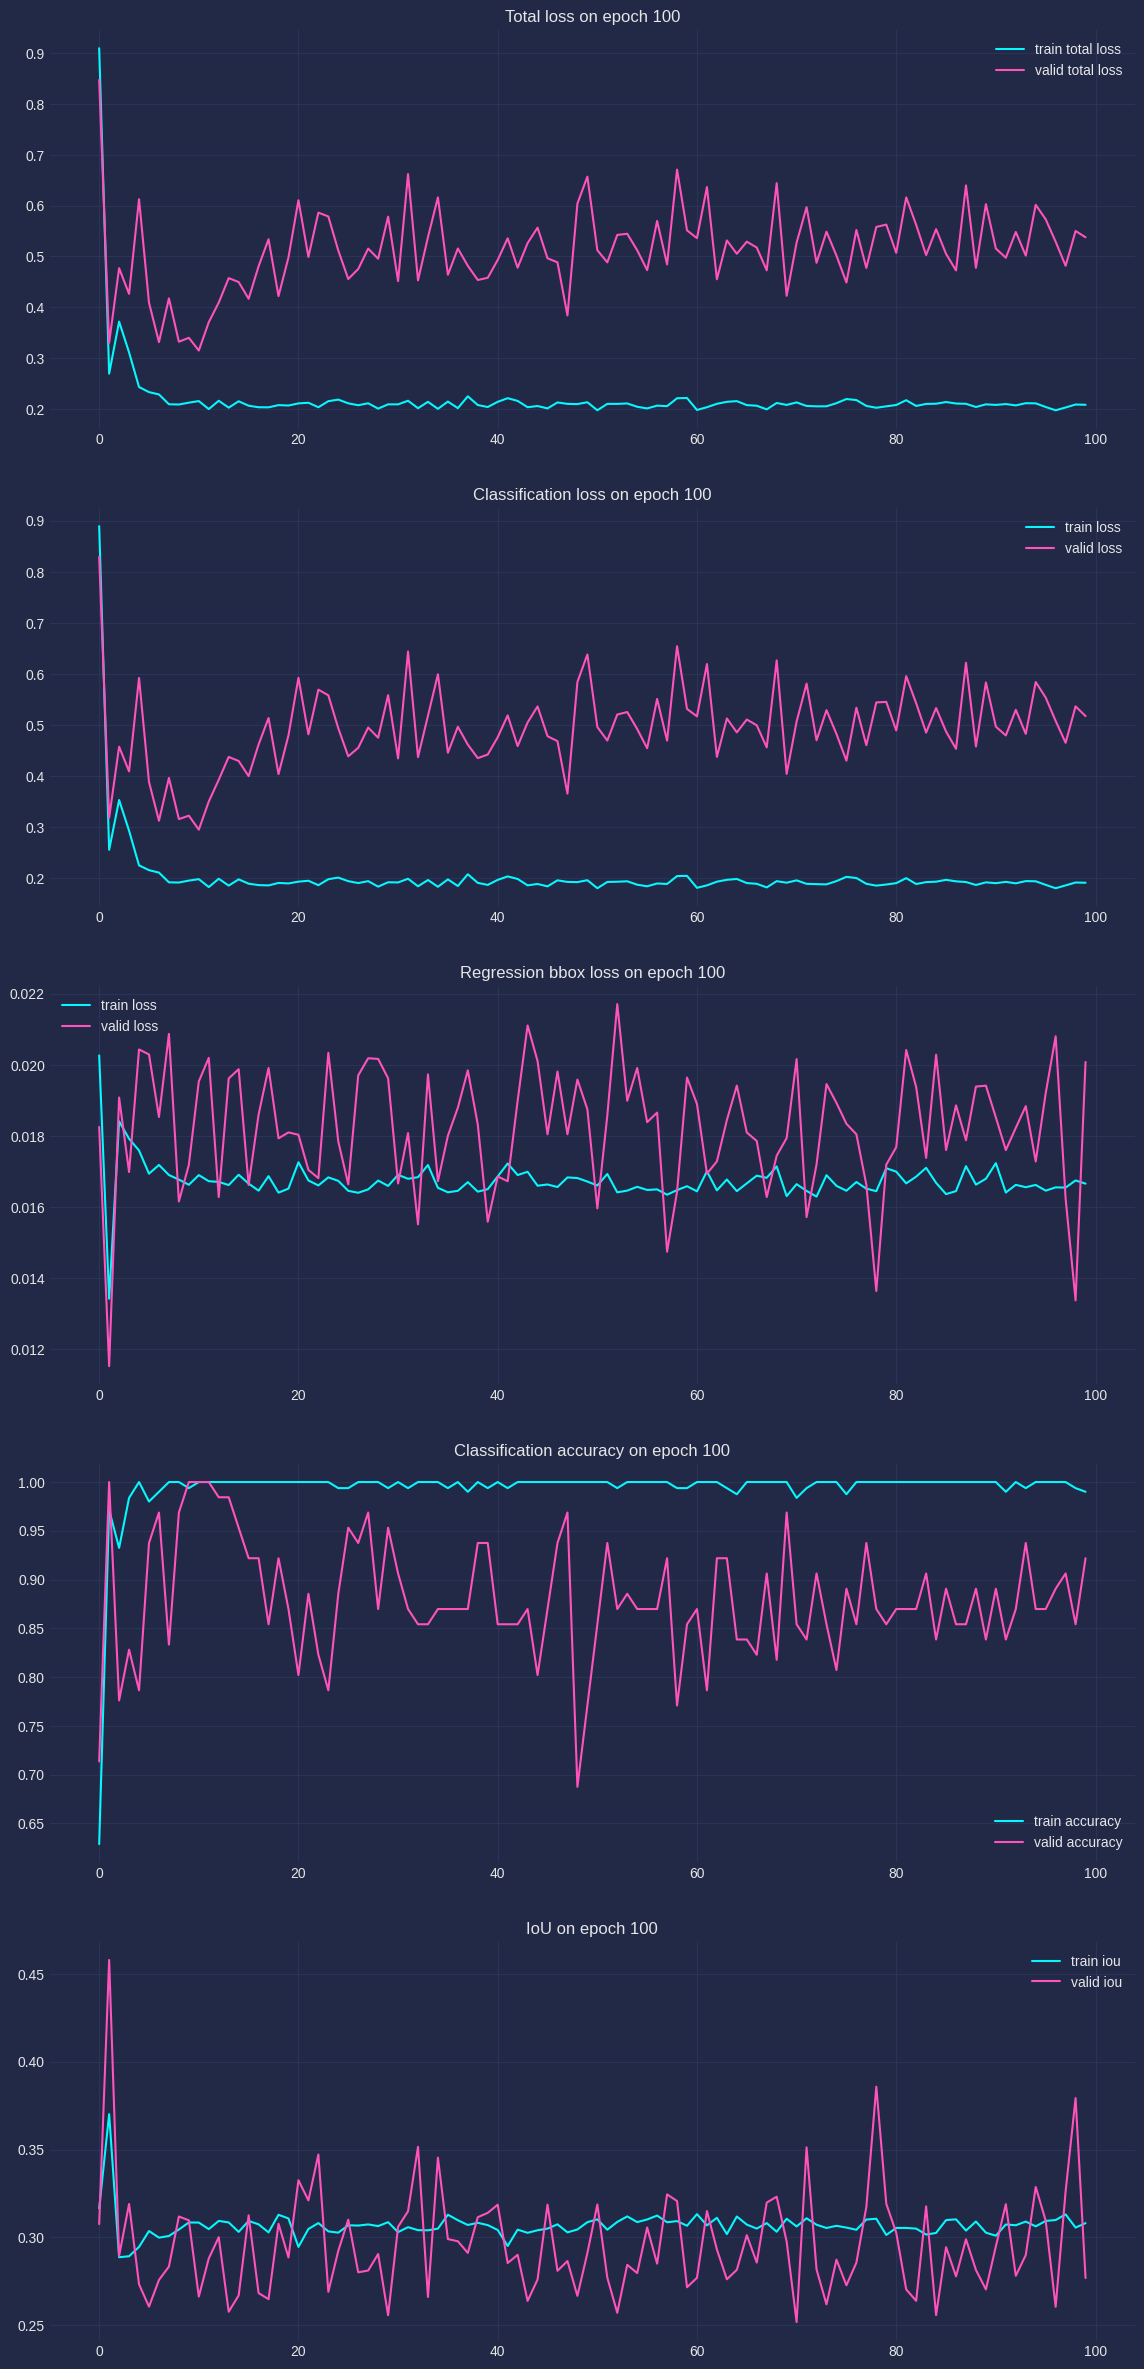

In [104]:
plot_history(log)

## 2 - transforms

In [130]:
train_aug = T.Compose(
    [   
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.3, 5.)),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.Resize((227, 227)),
        T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
valid_aug = T.Compose(
    [   
        T.Resize((227, 227)),
        T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
train_dataset = CustomDataset(root_dir='data/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='data/Veg/loc_valid', image_size=227, transform=valid_aug)

In [145]:
len(train_dataset)

148

In [146]:
len(valid_dataset)

38

In [131]:
model = LocModel()
model.to(device)

LocModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [132]:
clf_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=.9)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25])

/tmp/ipykernel_20430/761277677.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
/tmp/ipykernel_20430/761277677.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))


Epoch: 0  total_loss_train: 3.199, total_loss_valid: 1.165
	   train_clf_loss: 0.957, valid_clf_loss: 0.691
	   train_reg_loss: 2.242, valid_reg_loss: 0.474
	   train_clf_acc: 0.662, valid_clf_acc: 0.802
	   box_iou_train: 0.434, box_iou_valid: 0.564
Epoch: 1  total_loss_train: 1.116, total_loss_valid: 1.087
	   train_clf_loss: 0.382, valid_clf_loss: 0.665
	   train_reg_loss: 0.734, valid_reg_loss: 0.422
	   train_clf_acc: 0.981, valid_clf_acc: 0.792
	   box_iou_train: 0.583, box_iou_valid: 0.609
Epoch: 2  total_loss_train: 1.042, total_loss_valid: 1.310
	   train_clf_loss: 0.354, valid_clf_loss: 0.902
	   train_reg_loss: 0.688, valid_reg_loss: 0.408
	   train_clf_acc: 1.000, valid_clf_acc: 0.594
	   box_iou_train: 0.603, box_iou_valid: 0.560
Epoch: 3  total_loss_train: 0.886, total_loss_valid: 1.035
	   train_clf_loss: 0.237, valid_clf_loss: 0.641
	   train_reg_loss: 0.649, valid_reg_loss: 0.394
	   train_clf_acc: 1.000, valid_clf_acc: 0.776
	   box_iou_train: 0.607, box_iou_valid: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


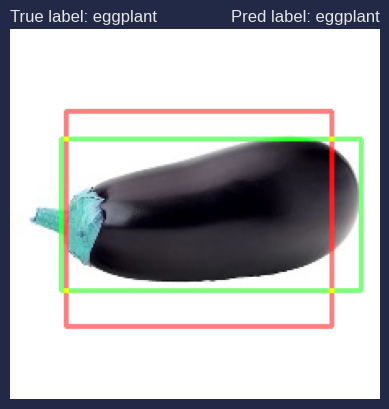

In [133]:
log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_reg_loss'] = []
log['epoch_valid_reg_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []

for i in range(100):
    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ####### обучающий шаг
    model.train()
    for true_label, true_box, image, filename  in train_loader:
        true_label = true_label.to(device)
        true_box = true_box.to(device)
        image = image.to(device)
        # filename = filename.to(device)
        preds_cls, preds_reg = model(image)
        
        loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
        batch_clf_loss.append(loss_cls.item())

        accuracy = ((preds_cls.argmax(axis=1) == true_label).cpu().numpy().mean())
        batch_acc.append(accuracy)

        loss_reg = F.huber_loss(preds_reg, true_box, reduction='sum', delta=.6)
        batch_reg_loss.append(loss_reg.item())

        iou = intersection_over_union(preds_reg, true_box).mean().item()
        batch_iou.append(iou)

        loss = loss_cls + loss_reg
        batch_total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))

    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []

    ######### валидационный шаг
    model.eval()
    for true_label, true_box, image, filename  in valid_loader:
        true_label = true_label.to(device)
        true_box = true_box.to(device)
        image = image.to(device)
        # filename = filename.to(device)
        with torch.inference_mode():
            preds_cls, preds_reg = model(image)
        loss_cls = F.cross_entropy(preds_cls, torch.tensor(true_label))
        batch_clf_loss.append(loss_cls.item())

        accuracy = ((preds_cls.argmax(axis=1) == true_label).cpu().numpy().mean())
        batch_acc.append(accuracy)

        loss_reg = F.huber_loss(preds_reg, true_box, reduction='sum', delta=.6)
        batch_reg_loss.append(loss_reg.item())

        iou = intersection_over_union(preds_reg, true_box).mean().item()  
        batch_iou.append(iou)

        loss = loss_cls + loss_reg
        batch_total_loss.append(loss.item())
        lr_scheduler.step()


    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_reg_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))

    print(f"Epoch: {i}  total_loss_train: {log['epoch_train_total_loss'][-1]:.3f}, total_loss_valid: {log['epoch_valid_total_loss'][-1]:.3f}")
    print(f"\t   train_clf_loss: {log['epoch_train_clf_loss'][-1]:.3f}, valid_clf_loss: {log['epoch_valid_clf_loss'][-1]:.3f}")
    print(f"\t   train_reg_loss: {log['epoch_train_reg_loss'][-1]:.3f}, valid_reg_loss: {log['epoch_valid_reg_loss'][-1]:.3f}")
    print(f"\t   train_clf_acc: {log['epoch_train_accuracy'][-1]:.3f}, valid_clf_acc: {log['epoch_valid_accuracy'][-1]:.3f}")
    print(f"\t   box_iou_train: {log['epoch_train_iou'][-1]:.3f}, box_iou_valid: {log['epoch_valid_iou'][-1]:.3f}")


    # реализуй визуализацию: рандомная картинка из батча, настоящая рамка, предсказанная рамка. Используй cv2.Rectangle
model.eval()
with torch.no_grad():
    true_label, true_box, image, filename = next(iter(valid_loader))
    true_label = true_label.to(device)
    true_box = true_box.to(device)
    image = image.to(device)
    preds_cls, preds_reg = model(image)

    rnd_index = random.randint(0, preds_cls.size(0) - 1)
    img = image[rnd_index].permute(1, 2, 0).cpu().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # true box coordinates
    true_box_coords = (true_box[rnd_index] * train_dataset.image_size).cpu().numpy().astype('int')
    true_box_img = cv2.rectangle(
        img.copy(),
        (true_box_coords[0], true_box_coords[1]), # top left
        (true_box_coords[2], true_box_coords[3]), # bottom right
        color=(0, 255, 0), thickness=2
    )

    # predicted box coordinates
    pred_box_coords = (preds_reg[rnd_index] * train_dataset.image_size).cpu().detach().numpy().astype('int')
    pred_box_img = cv2.rectangle(
        img.copy(),
        (pred_box_coords[0], pred_box_coords[1]), # top left
        (pred_box_coords[2], pred_box_coords[3]), # bottom right
        color=(255, 0, 0), thickness=2
    )

    # combine true and predicted boxes on the same image
    combined_img = cv2.addWeighted(true_box_img, 0.5, pred_box_img, 0.5, 0)

    # plot the image with true and predicted boxes
    fig, ax = plt.subplots(1, 1, squeeze=True)
    ax.imshow(combined_img)
    ax.set_axis_off()
    plt.title(f'True label: {train_dataset.ix2cls[true_label[rnd_index].item()]} \
               Pred label: {train_dataset.ix2cls[preds_cls[rnd_index].argmax().item()]}')
    plt.show()

In [157]:
log['epoch_valid_clf_loss'][-1]

0.2174551710486412

In [158]:
import pandas as pd

In [159]:
df = pd.DataFrame(index=['Classification loss', 'Regression loss', 'Total loss', 'Accuracy', 'IoU'], columns=['Train', 'Valid'])

In [187]:
df['Metrics'] = df.index

In [190]:
df

,Train,Valid
Classification loss,0.162,0.217
Regression loss,0.609,0.368
Total loss,0.771,0.585
Accuracy,1.0,0.984
IoU,0.62,0.631


In [191]:
df.to_csv('metrics_1.csv', index=True)

In [184]:
# df.loc['IoU', 'Train'] = round(log['epoch_train_iou'][-1], 3)

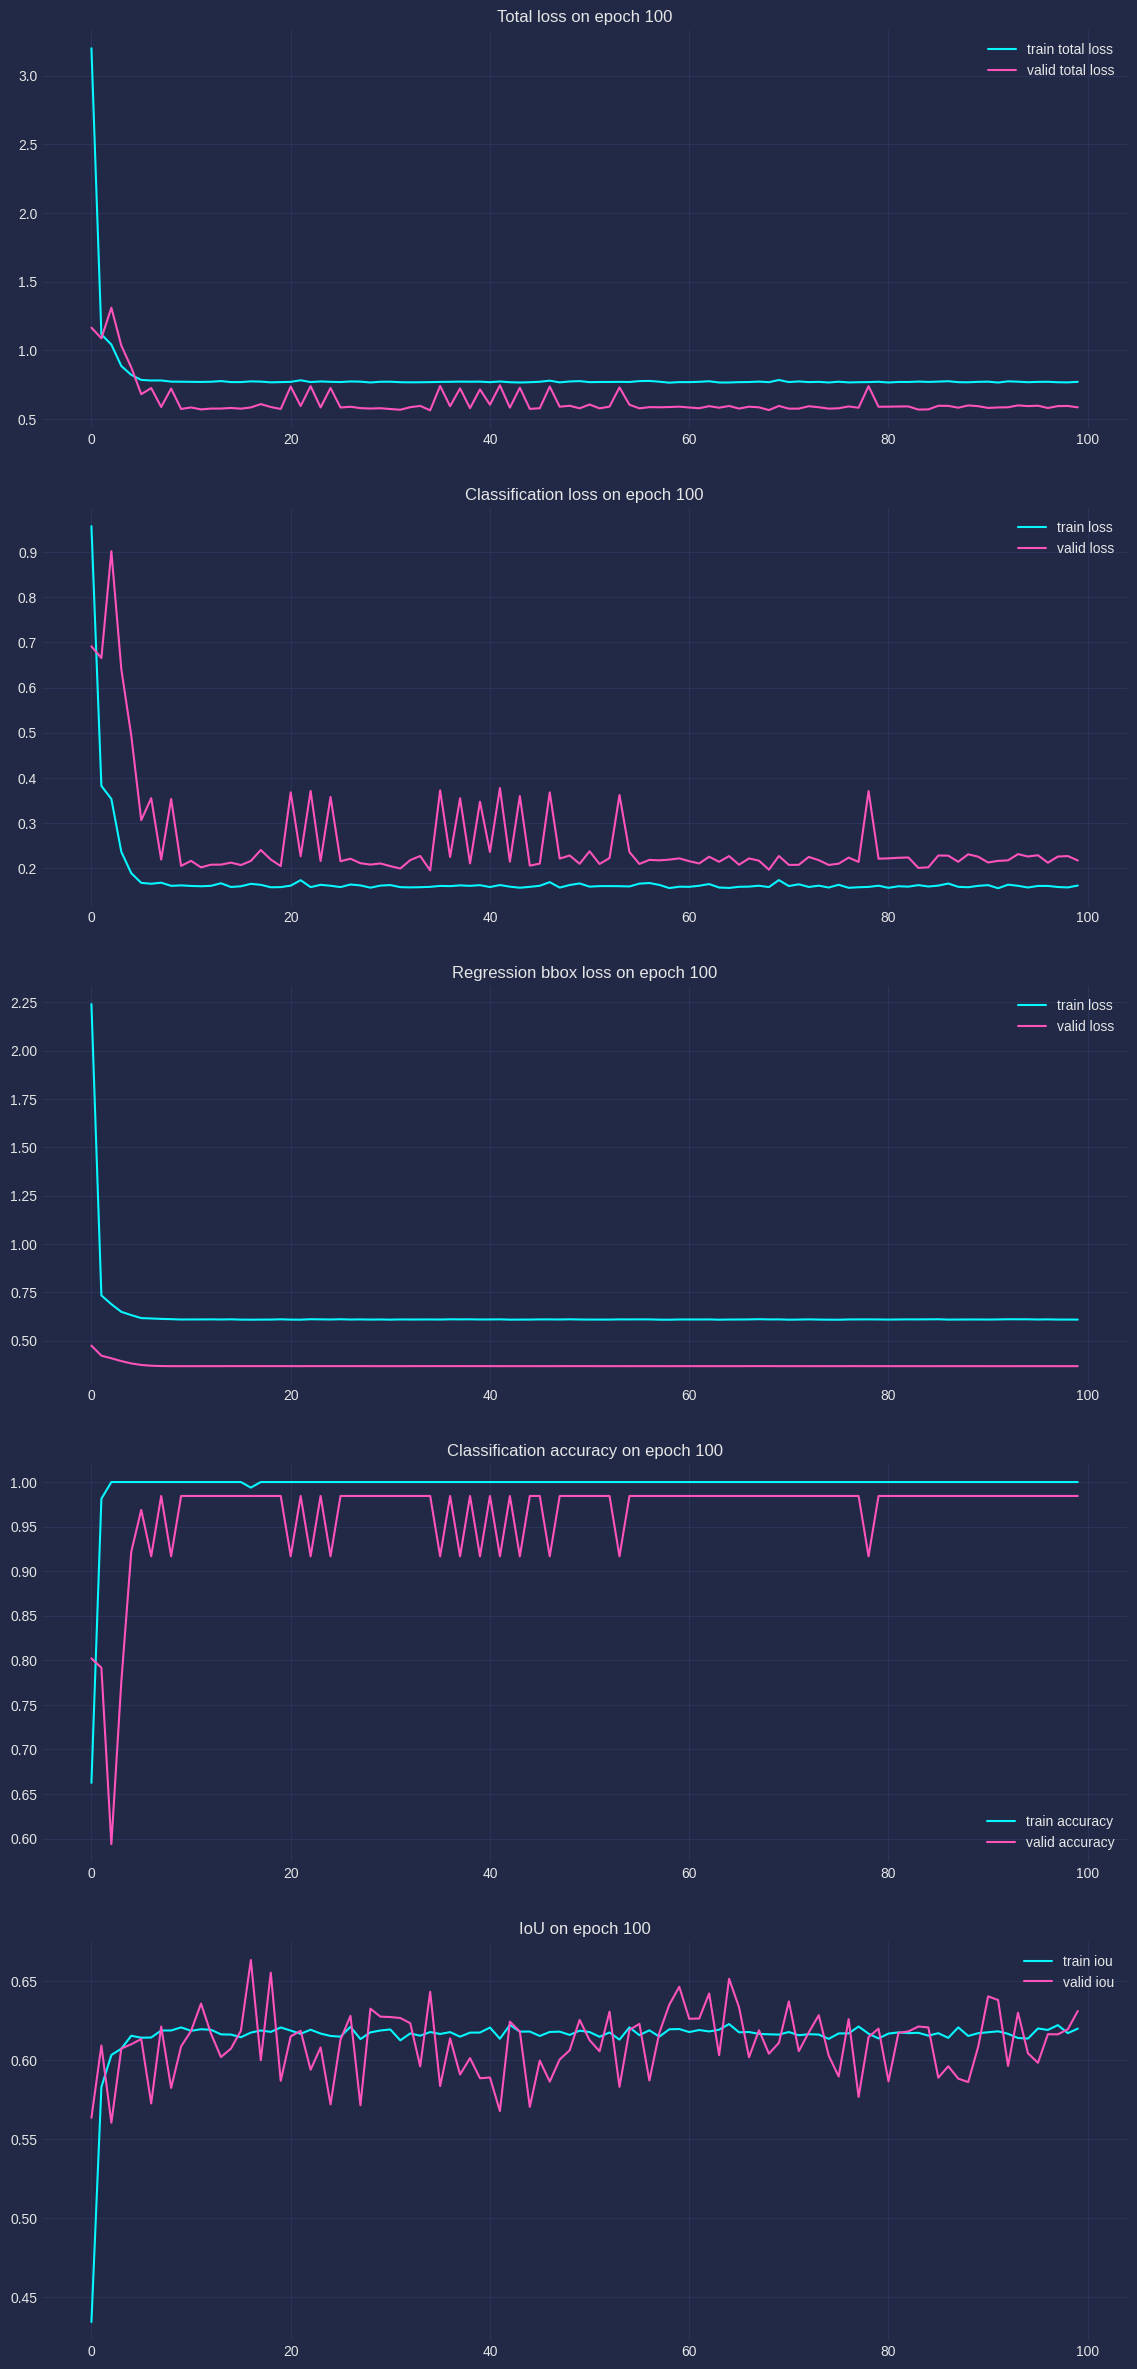

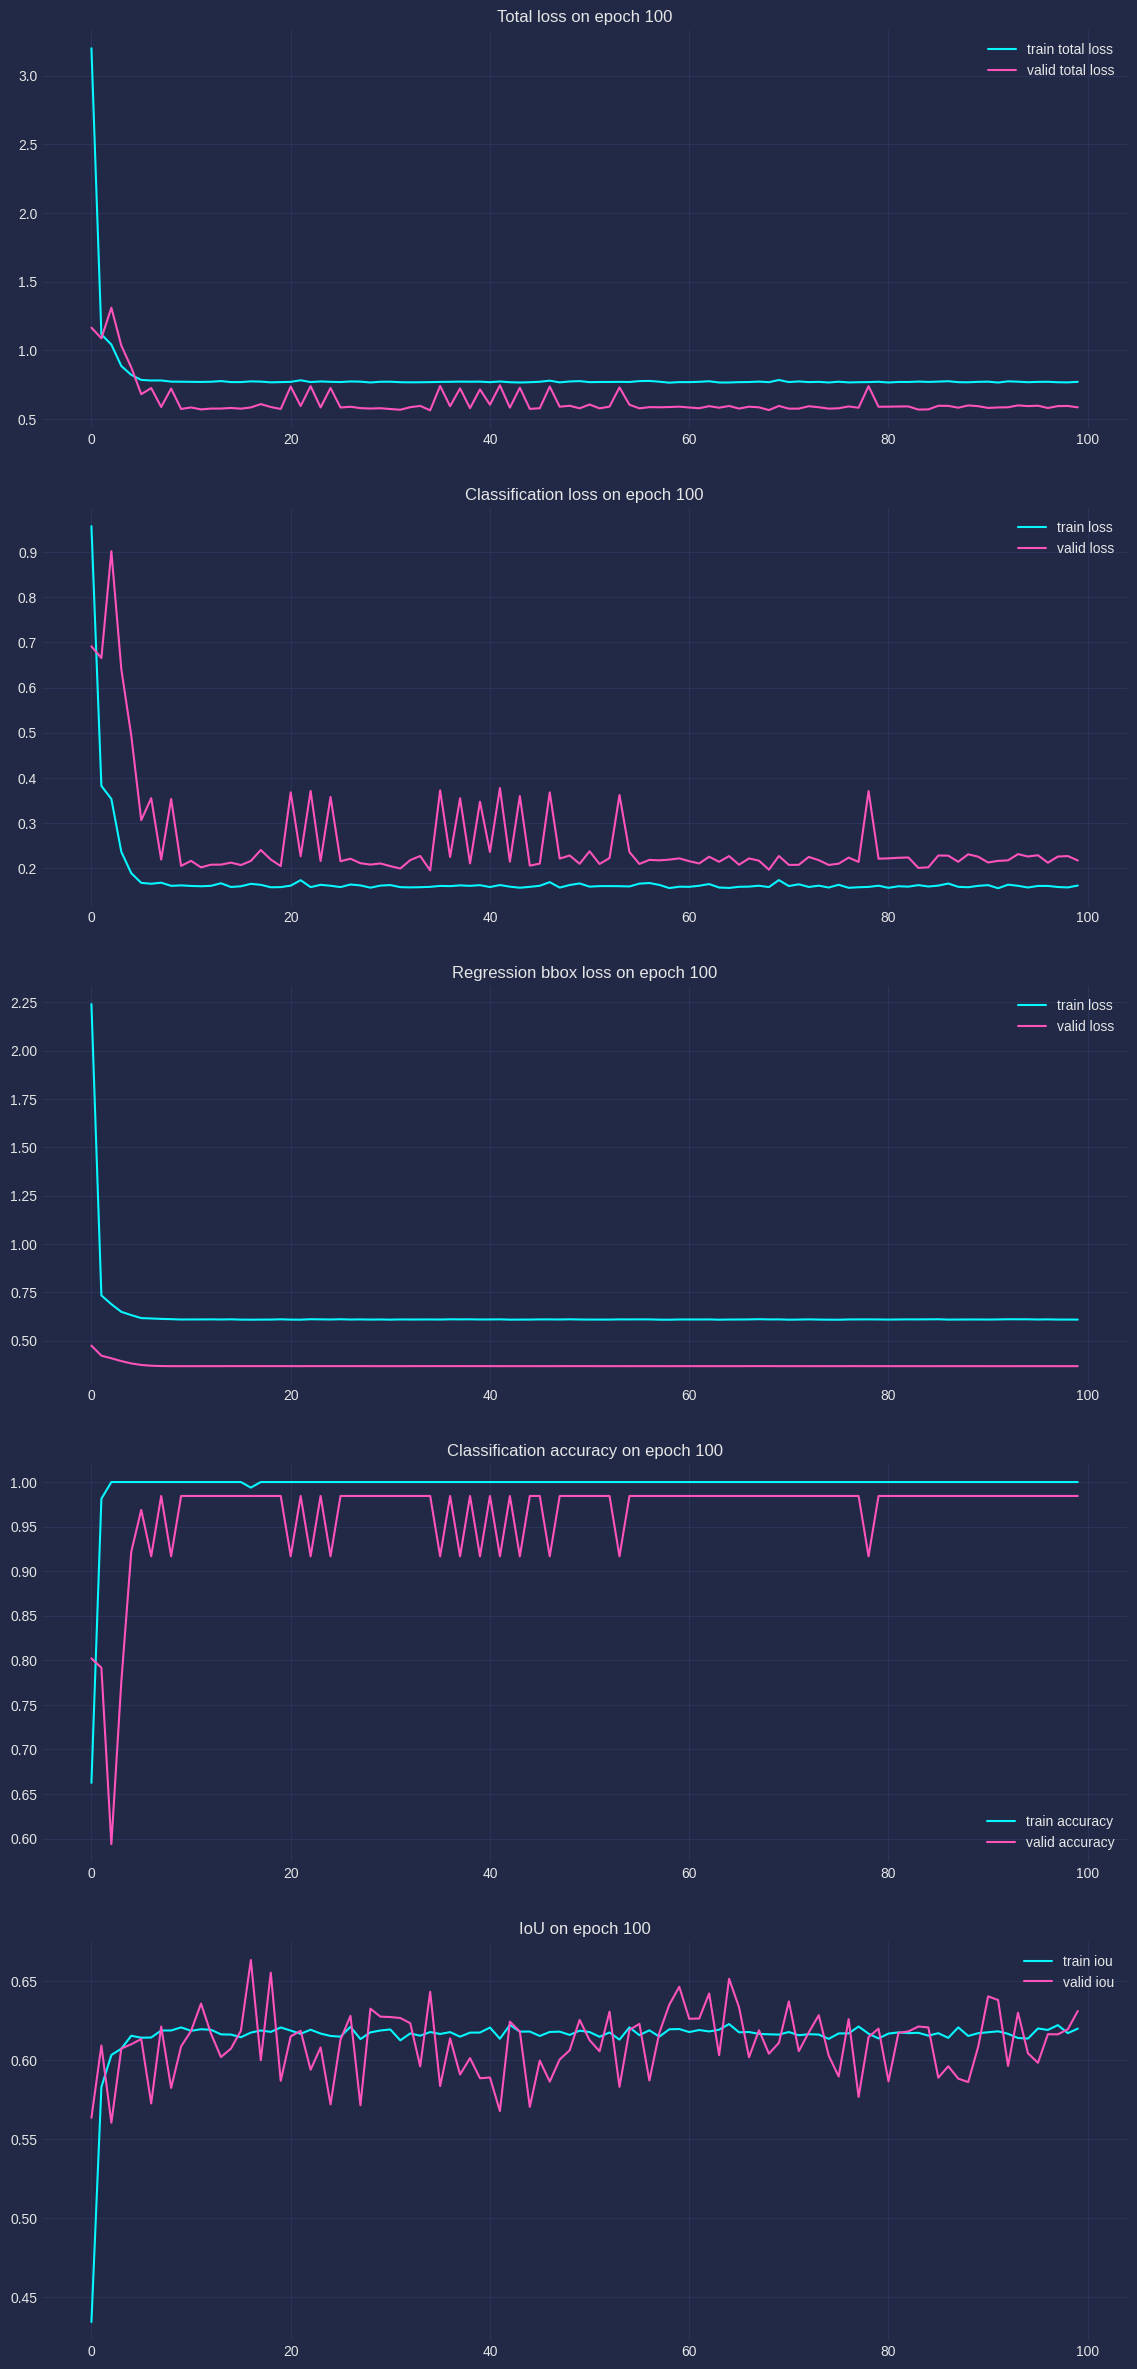

In [134]:
plot_history(log)

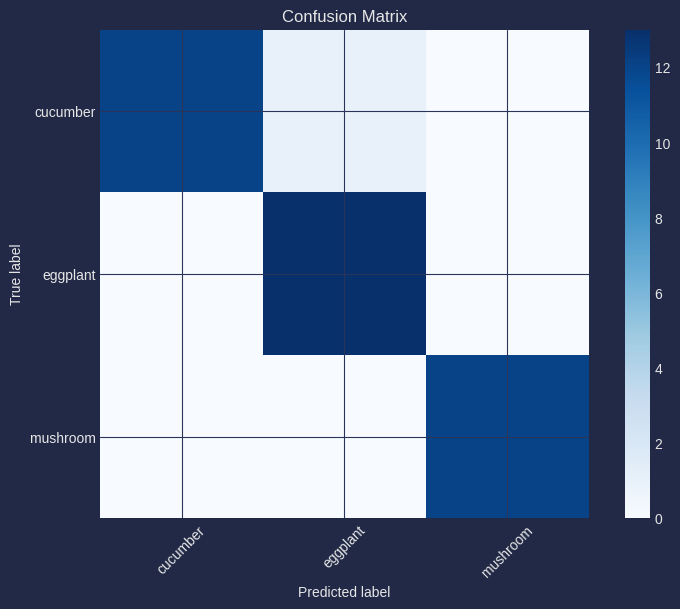

In [155]:
from sklearn.metrics import confusion_matrix

# Получение предсказаний модели
y_true = []
y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for true_label, true_box, image, filename in valid_loader:
    true_label = true_label.to(device)  # Переместить метки на устройство (GPU)
    true_box = true_box.to(device)      # Переместить истинные боксы на устройство (GPU)
    image = image.to(device)            # Переместить изображения на устройство (GPU)

    outputs = model(image)
    _, predicted = torch.max(outputs[0], 1)
    y_true.extend(true_label.cpu().numpy())   # Преобразовать метки обратно на устройство (CPU) для дальнейшей обработки
    y_pred.extend(predicted.cpu().numpy())    # Преобразовать предсказанные метки обратно на устройство (CPU) для дальнейшей обработки

# Построение confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(ix2cls)), normalize=None)

# Отрисовка confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Получение уникальных меток классов
unique_labels = [ix2cls[i] for i in range(len(ix2cls))]
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [128]:
fig.savefig('training_history.png')

In [135]:
# Assuming 'model' is your model instance
torch.save(model.state_dict(), 'model_weights_2.pth')

In [136]:
torch.save(model, 'entire_model_2.pt')

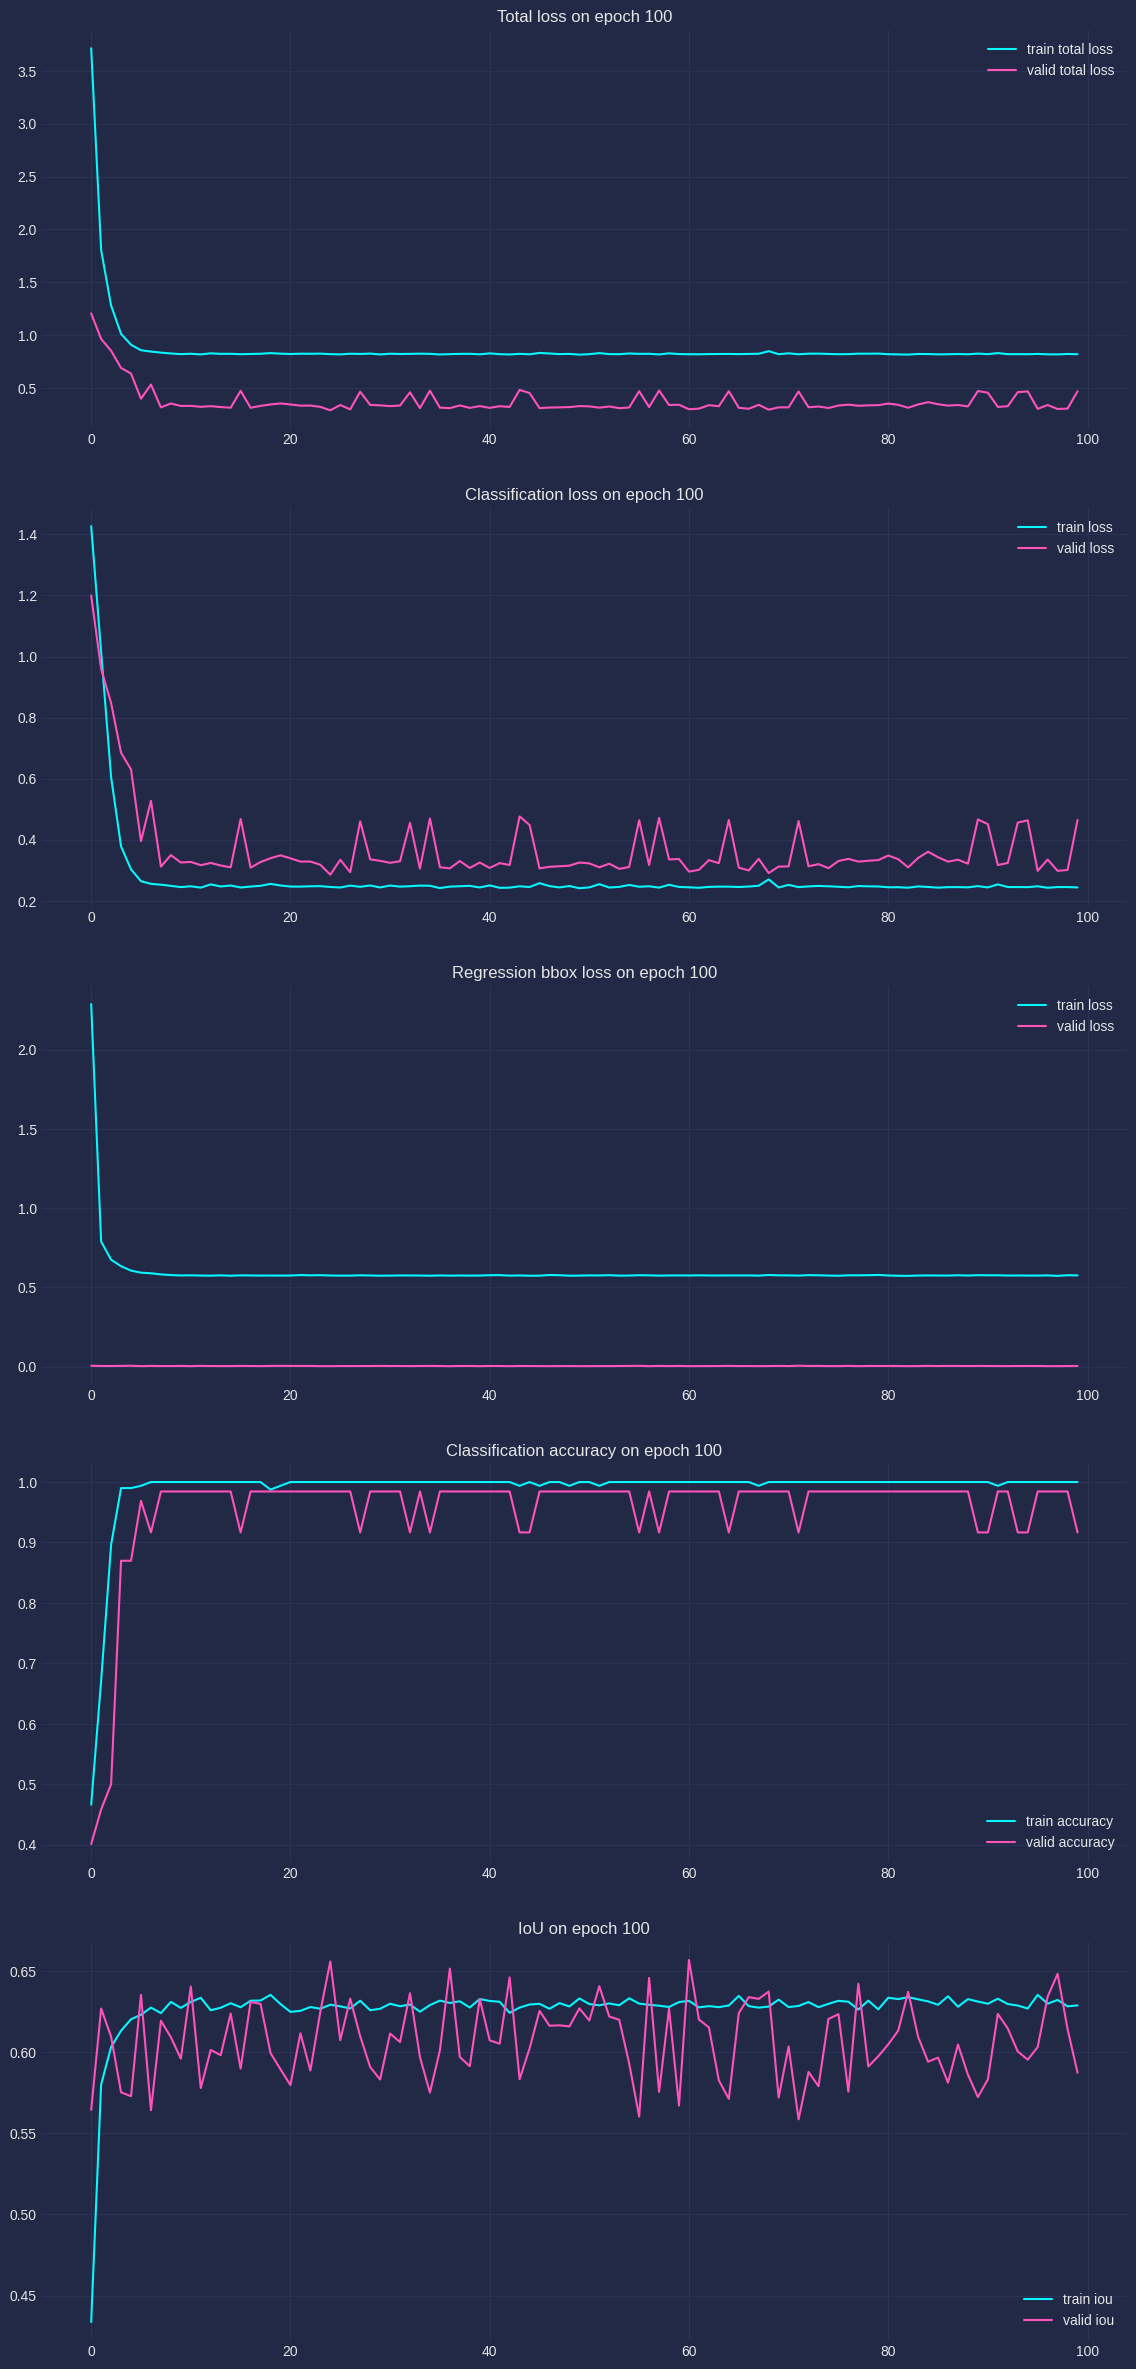

In [129]:
def plot_history(log, grid=True):
    fig, ax = plt.subplots(5, 1, figsize=(14, 30))
    
    ax[0].plot(log['epoch_train_total_loss'], label='train total loss')
    ax[0].plot(log['epoch_valid_total_loss'], label='valid total loss')
    ax[0].set_title(f"Total loss on epoch {len(log['epoch_train_total_loss'])}")
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(log['epoch_train_clf_loss'], label='train loss')
    ax[1].plot(log['epoch_valid_clf_loss'], label='valid loss')
    ax[1].set_title(f"Classification loss on epoch {len(log['epoch_train_total_loss'])}")
    ax[1].grid(grid)
    ax[1].legend()

    ax[2].plot(log['epoch_train_reg_loss'], label='train loss')
    ax[2].plot(log['epoch_valid_reg_loss'], label='valid loss')
    ax[2].set_title(f"Regression bbox loss on epoch {len(log['epoch_train_total_loss'])}")
    ax[2].grid(grid)
    ax[2].legend()

    ax[3].plot(log['epoch_train_accuracy'], label='train accuracy')
    ax[3].plot(log['epoch_valid_accuracy'], label='valid accuracy')
    ax[3].set_title(f"Classification accuracy on epoch {len(log['epoch_train_total_loss'])}")
    ax[3].grid(grid)
    ax[3].legend()

    ax[4].plot(log['epoch_train_iou'], label='train iou')
    ax[4].plot(log['epoch_valid_iou'], label='valid iou')
    ax[4].set_title(f"IoU on epoch {len(log['epoch_train_total_loss'])}")
    ax[4].grid(grid)
    ax[4].legend()

    plt.show()
    return fig

# Построение графика и сохранение результата



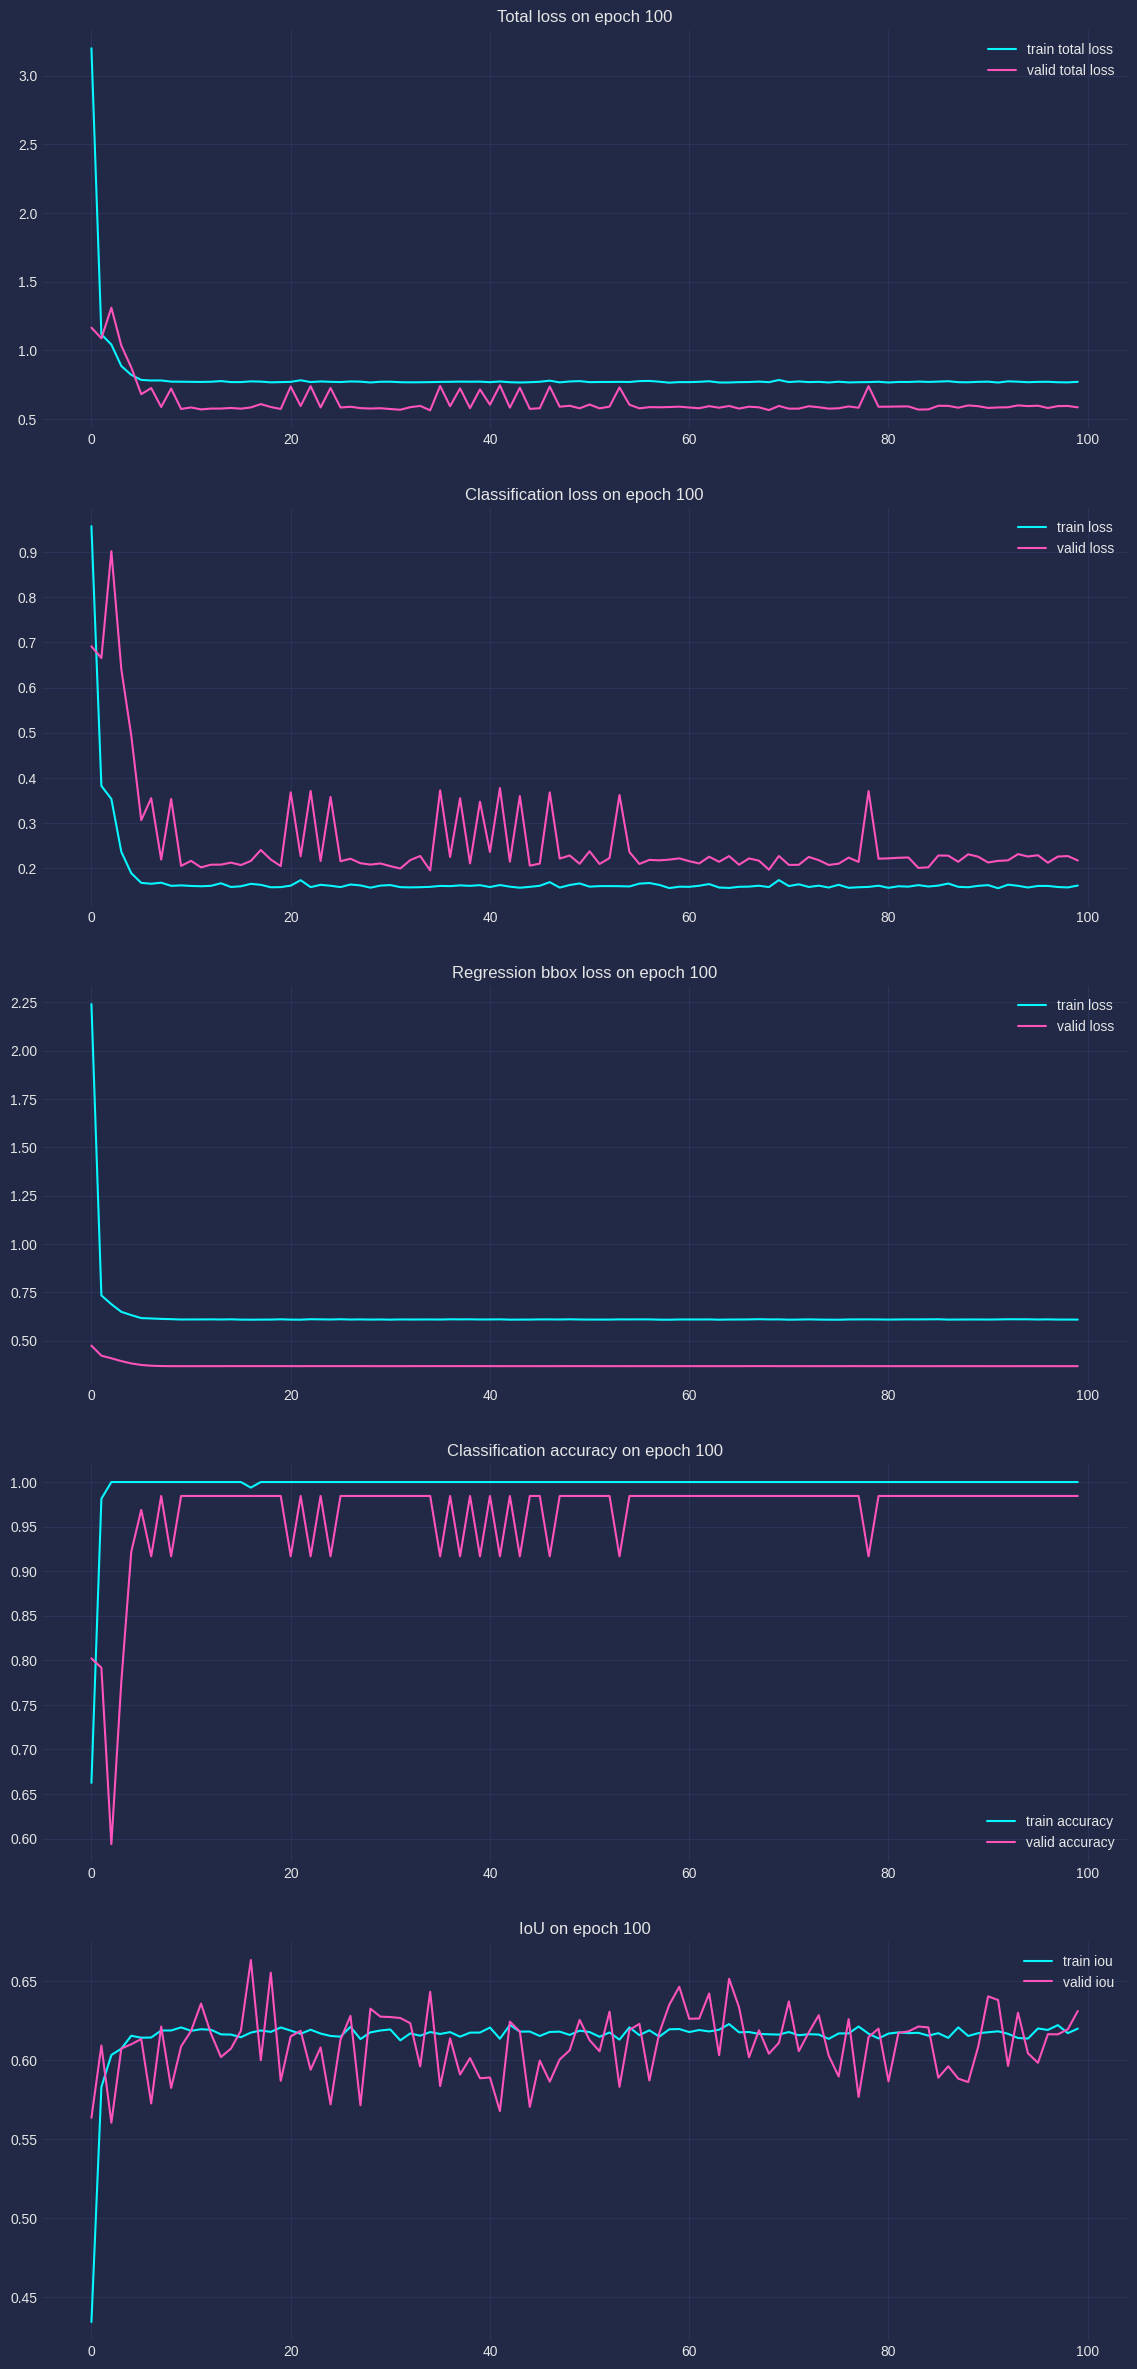

In [137]:
fig = plot_history(log)
fig.savefig('training_history_2.png')

In [138]:
cls2ix = {
    'cucumber' : 0, 
    'eggplant' : 1, 
    'mushroom' : 2
    }
# и наоборот
ix2cls = {v: k for k, v in cls2ix.items()}

In [139]:
cls2ix

{'cucumber': 0, 'eggplant': 1, 'mushroom': 2}

In [141]:
ix2cls = {0: 'cucumber', 1: 'eggplant', 2: 'mushroom'}

In [1]:
weights = {
    'Axial': 'models/model2/besaxial_40epoch.pt',
    'Coronal': 'models/model2/best_brain_coronal_50+50.pt',
    'Sagittal': 'models/model2/best_brain_sagittal_70_epoch_yolov5l.pt'
}

In [2]:
weights['Axial']

'models/model2/besaxial_40epoch.pt'

In [3]:
import torch

In [4]:
model_ax = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=False)

Using cache found in /home/vera/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-23 Python-3.10.14 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1050, 4041MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256

In [5]:
model_ax.load_state_dict(torch.load('models/model2/besaxial_40epoch.pt'))

RuntimeError: Error(s) in loading state_dict for DetectionModel:
	Missing key(s) in state_dict: "model.0.conv.weight", "model.0.bn.weight", "model.0.bn.bias", "model.0.bn.running_mean", "model.0.bn.running_var", "model.1.conv.weight", "model.1.bn.weight", "model.1.bn.bias", "model.1.bn.running_mean", "model.1.bn.running_var", "model.2.cv1.conv.weight", "model.2.cv1.bn.weight", "model.2.cv1.bn.bias", "model.2.cv1.bn.running_mean", "model.2.cv1.bn.running_var", "model.2.cv2.conv.weight", "model.2.cv2.bn.weight", "model.2.cv2.bn.bias", "model.2.cv2.bn.running_mean", "model.2.cv2.bn.running_var", "model.2.cv3.conv.weight", "model.2.cv3.bn.weight", "model.2.cv3.bn.bias", "model.2.cv3.bn.running_mean", "model.2.cv3.bn.running_var", "model.2.m.0.cv1.conv.weight", "model.2.m.0.cv1.bn.weight", "model.2.m.0.cv1.bn.bias", "model.2.m.0.cv1.bn.running_mean", "model.2.m.0.cv1.bn.running_var", "model.2.m.0.cv2.conv.weight", "model.2.m.0.cv2.bn.weight", "model.2.m.0.cv2.bn.bias", "model.2.m.0.cv2.bn.running_mean", "model.2.m.0.cv2.bn.running_var", "model.3.conv.weight", "model.3.bn.weight", "model.3.bn.bias", "model.3.bn.running_mean", "model.3.bn.running_var", "model.4.cv1.conv.weight", "model.4.cv1.bn.weight", "model.4.cv1.bn.bias", "model.4.cv1.bn.running_mean", "model.4.cv1.bn.running_var", "model.4.cv2.conv.weight", "model.4.cv2.bn.weight", "model.4.cv2.bn.bias", "model.4.cv2.bn.running_mean", "model.4.cv2.bn.running_var", "model.4.cv3.conv.weight", "model.4.cv3.bn.weight", "model.4.cv3.bn.bias", "model.4.cv3.bn.running_mean", "model.4.cv3.bn.running_var", "model.4.m.0.cv1.conv.weight", "model.4.m.0.cv1.bn.weight", "model.4.m.0.cv1.bn.bias", "model.4.m.0.cv1.bn.running_mean", "model.4.m.0.cv1.bn.running_var", "model.4.m.0.cv2.conv.weight", "model.4.m.0.cv2.bn.weight", "model.4.m.0.cv2.bn.bias", "model.4.m.0.cv2.bn.running_mean", "model.4.m.0.cv2.bn.running_var", "model.4.m.1.cv1.conv.weight", "model.4.m.1.cv1.bn.weight", "model.4.m.1.cv1.bn.bias", "model.4.m.1.cv1.bn.running_mean", "model.4.m.1.cv1.bn.running_var", "model.4.m.1.cv2.conv.weight", "model.4.m.1.cv2.bn.weight", "model.4.m.1.cv2.bn.bias", "model.4.m.1.cv2.bn.running_mean", "model.4.m.1.cv2.bn.running_var", "model.5.conv.weight", "model.5.bn.weight", "model.5.bn.bias", "model.5.bn.running_mean", "model.5.bn.running_var", "model.6.cv1.conv.weight", "model.6.cv1.bn.weight", "model.6.cv1.bn.bias", "model.6.cv1.bn.running_mean", "model.6.cv1.bn.running_var", "model.6.cv2.conv.weight", "model.6.cv2.bn.weight", "model.6.cv2.bn.bias", "model.6.cv2.bn.running_mean", "model.6.cv2.bn.running_var", "model.6.cv3.conv.weight", "model.6.cv3.bn.weight", "model.6.cv3.bn.bias", "model.6.cv3.bn.running_mean", "model.6.cv3.bn.running_var", "model.6.m.0.cv1.conv.weight", "model.6.m.0.cv1.bn.weight", "model.6.m.0.cv1.bn.bias", "model.6.m.0.cv1.bn.running_mean", "model.6.m.0.cv1.bn.running_var", "model.6.m.0.cv2.conv.weight", "model.6.m.0.cv2.bn.weight", "model.6.m.0.cv2.bn.bias", "model.6.m.0.cv2.bn.running_mean", "model.6.m.0.cv2.bn.running_var", "model.6.m.1.cv1.conv.weight", "model.6.m.1.cv1.bn.weight", "model.6.m.1.cv1.bn.bias", "model.6.m.1.cv1.bn.running_mean", "model.6.m.1.cv1.bn.running_var", "model.6.m.1.cv2.conv.weight", "model.6.m.1.cv2.bn.weight", "model.6.m.1.cv2.bn.bias", "model.6.m.1.cv2.bn.running_mean", "model.6.m.1.cv2.bn.running_var", "model.6.m.2.cv1.conv.weight", "model.6.m.2.cv1.bn.weight", "model.6.m.2.cv1.bn.bias", "model.6.m.2.cv1.bn.running_mean", "model.6.m.2.cv1.bn.running_var", "model.6.m.2.cv2.conv.weight", "model.6.m.2.cv2.bn.weight", "model.6.m.2.cv2.bn.bias", "model.6.m.2.cv2.bn.running_mean", "model.6.m.2.cv2.bn.running_var", "model.7.conv.weight", "model.7.bn.weight", "model.7.bn.bias", "model.7.bn.running_mean", "model.7.bn.running_var", "model.8.cv1.conv.weight", "model.8.cv1.bn.weight", "model.8.cv1.bn.bias", "model.8.cv1.bn.running_mean", "model.8.cv1.bn.running_var", "model.8.cv2.conv.weight", "model.8.cv2.bn.weight", "model.8.cv2.bn.bias", "model.8.cv2.bn.running_mean", "model.8.cv2.bn.running_var", "model.8.cv3.conv.weight", "model.8.cv3.bn.weight", "model.8.cv3.bn.bias", "model.8.cv3.bn.running_mean", "model.8.cv3.bn.running_var", "model.8.m.0.cv1.conv.weight", "model.8.m.0.cv1.bn.weight", "model.8.m.0.cv1.bn.bias", "model.8.m.0.cv1.bn.running_mean", "model.8.m.0.cv1.bn.running_var", "model.8.m.0.cv2.conv.weight", "model.8.m.0.cv2.bn.weight", "model.8.m.0.cv2.bn.bias", "model.8.m.0.cv2.bn.running_mean", "model.8.m.0.cv2.bn.running_var", "model.9.cv1.conv.weight", "model.9.cv1.bn.weight", "model.9.cv1.bn.bias", "model.9.cv1.bn.running_mean", "model.9.cv1.bn.running_var", "model.9.cv2.conv.weight", "model.9.cv2.bn.weight", "model.9.cv2.bn.bias", "model.9.cv2.bn.running_mean", "model.9.cv2.bn.running_var", "model.10.conv.weight", "model.10.bn.weight", "model.10.bn.bias", "model.10.bn.running_mean", "model.10.bn.running_var", "model.13.cv1.conv.weight", "model.13.cv1.bn.weight", "model.13.cv1.bn.bias", "model.13.cv1.bn.running_mean", "model.13.cv1.bn.running_var", "model.13.cv2.conv.weight", "model.13.cv2.bn.weight", "model.13.cv2.bn.bias", "model.13.cv2.bn.running_mean", "model.13.cv2.bn.running_var", "model.13.cv3.conv.weight", "model.13.cv3.bn.weight", "model.13.cv3.bn.bias", "model.13.cv3.bn.running_mean", "model.13.cv3.bn.running_var", "model.13.m.0.cv1.conv.weight", "model.13.m.0.cv1.bn.weight", "model.13.m.0.cv1.bn.bias", "model.13.m.0.cv1.bn.running_mean", "model.13.m.0.cv1.bn.running_var", "model.13.m.0.cv2.conv.weight", "model.13.m.0.cv2.bn.weight", "model.13.m.0.cv2.bn.bias", "model.13.m.0.cv2.bn.running_mean", "model.13.m.0.cv2.bn.running_var", "model.14.conv.weight", "model.14.bn.weight", "model.14.bn.bias", "model.14.bn.running_mean", "model.14.bn.running_var", "model.17.cv1.conv.weight", "model.17.cv1.bn.weight", "model.17.cv1.bn.bias", "model.17.cv1.bn.running_mean", "model.17.cv1.bn.running_var", "model.17.cv2.conv.weight", "model.17.cv2.bn.weight", "model.17.cv2.bn.bias", "model.17.cv2.bn.running_mean", "model.17.cv2.bn.running_var", "model.17.cv3.conv.weight", "model.17.cv3.bn.weight", "model.17.cv3.bn.bias", "model.17.cv3.bn.running_mean", "model.17.cv3.bn.running_var", "model.17.m.0.cv1.conv.weight", "model.17.m.0.cv1.bn.weight", "model.17.m.0.cv1.bn.bias", "model.17.m.0.cv1.bn.running_mean", "model.17.m.0.cv1.bn.running_var", "model.17.m.0.cv2.conv.weight", "model.17.m.0.cv2.bn.weight", "model.17.m.0.cv2.bn.bias", "model.17.m.0.cv2.bn.running_mean", "model.17.m.0.cv2.bn.running_var", "model.18.conv.weight", "model.18.bn.weight", "model.18.bn.bias", "model.18.bn.running_mean", "model.18.bn.running_var", "model.20.cv1.conv.weight", "model.20.cv1.bn.weight", "model.20.cv1.bn.bias", "model.20.cv1.bn.running_mean", "model.20.cv1.bn.running_var", "model.20.cv2.conv.weight", "model.20.cv2.bn.weight", "model.20.cv2.bn.bias", "model.20.cv2.bn.running_mean", "model.20.cv2.bn.running_var", "model.20.cv3.conv.weight", "model.20.cv3.bn.weight", "model.20.cv3.bn.bias", "model.20.cv3.bn.running_mean", "model.20.cv3.bn.running_var", "model.20.m.0.cv1.conv.weight", "model.20.m.0.cv1.bn.weight", "model.20.m.0.cv1.bn.bias", "model.20.m.0.cv1.bn.running_mean", "model.20.m.0.cv1.bn.running_var", "model.20.m.0.cv2.conv.weight", "model.20.m.0.cv2.bn.weight", "model.20.m.0.cv2.bn.bias", "model.20.m.0.cv2.bn.running_mean", "model.20.m.0.cv2.bn.running_var", "model.21.conv.weight", "model.21.bn.weight", "model.21.bn.bias", "model.21.bn.running_mean", "model.21.bn.running_var", "model.23.cv1.conv.weight", "model.23.cv1.bn.weight", "model.23.cv1.bn.bias", "model.23.cv1.bn.running_mean", "model.23.cv1.bn.running_var", "model.23.cv2.conv.weight", "model.23.cv2.bn.weight", "model.23.cv2.bn.bias", "model.23.cv2.bn.running_mean", "model.23.cv2.bn.running_var", "model.23.cv3.conv.weight", "model.23.cv3.bn.weight", "model.23.cv3.bn.bias", "model.23.cv3.bn.running_mean", "model.23.cv3.bn.running_var", "model.23.m.0.cv1.conv.weight", "model.23.m.0.cv1.bn.weight", "model.23.m.0.cv1.bn.bias", "model.23.m.0.cv1.bn.running_mean", "model.23.m.0.cv1.bn.running_var", "model.23.m.0.cv2.conv.weight", "model.23.m.0.cv2.bn.weight", "model.23.m.0.cv2.bn.bias", "model.23.m.0.cv2.bn.running_mean", "model.23.m.0.cv2.bn.running_var", "model.24.anchors", "model.24.m.0.weight", "model.24.m.0.bias", "model.24.m.1.weight", "model.24.m.1.bias", "model.24.m.2.weight", "model.24.m.2.bias". 
	Unexpected key(s) in state_dict: "epoch", "best_fitness", "ema", "updates", "optimizer", "opt", "git", "date". 

In [6]:
model_cor = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=False)
model_cor.load_state_dict(torch.load('models/model2/best_brain_coronal_50+50.pt'))

Using cache found in /home/vera/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-23 Python-3.10.14 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1050, 4041MiB)


                 from  n    params  module                                  arguments                     
  0                -1  1      5280  models.common.Conv                      [3, 48, 6, 2, 2]              
  1                -1  1     41664  models.common.Conv                      [48, 96, 3, 2]                
  2                -1  2     65280  models.common.C3                        [96, 96, 2]                   
  3                -1  1    166272  models.common.Conv                      [96, 192, 3, 2]               
  4                -1  4    444672  models.common.C3                        [192, 192, 4]                 
  5                -1  1    664320  models.common.Conv                      [192, 384, 3, 2]              
  6                -1  6   2512896  models.common.C3                        [384

RuntimeError: Error(s) in loading state_dict for DetectionModel:
	Missing key(s) in state_dict: "model.0.conv.weight", "model.0.bn.weight", "model.0.bn.bias", "model.0.bn.running_mean", "model.0.bn.running_var", "model.1.conv.weight", "model.1.bn.weight", "model.1.bn.bias", "model.1.bn.running_mean", "model.1.bn.running_var", "model.2.cv1.conv.weight", "model.2.cv1.bn.weight", "model.2.cv1.bn.bias", "model.2.cv1.bn.running_mean", "model.2.cv1.bn.running_var", "model.2.cv2.conv.weight", "model.2.cv2.bn.weight", "model.2.cv2.bn.bias", "model.2.cv2.bn.running_mean", "model.2.cv2.bn.running_var", "model.2.cv3.conv.weight", "model.2.cv3.bn.weight", "model.2.cv3.bn.bias", "model.2.cv3.bn.running_mean", "model.2.cv3.bn.running_var", "model.2.m.0.cv1.conv.weight", "model.2.m.0.cv1.bn.weight", "model.2.m.0.cv1.bn.bias", "model.2.m.0.cv1.bn.running_mean", "model.2.m.0.cv1.bn.running_var", "model.2.m.0.cv2.conv.weight", "model.2.m.0.cv2.bn.weight", "model.2.m.0.cv2.bn.bias", "model.2.m.0.cv2.bn.running_mean", "model.2.m.0.cv2.bn.running_var", "model.2.m.1.cv1.conv.weight", "model.2.m.1.cv1.bn.weight", "model.2.m.1.cv1.bn.bias", "model.2.m.1.cv1.bn.running_mean", "model.2.m.1.cv1.bn.running_var", "model.2.m.1.cv2.conv.weight", "model.2.m.1.cv2.bn.weight", "model.2.m.1.cv2.bn.bias", "model.2.m.1.cv2.bn.running_mean", "model.2.m.1.cv2.bn.running_var", "model.3.conv.weight", "model.3.bn.weight", "model.3.bn.bias", "model.3.bn.running_mean", "model.3.bn.running_var", "model.4.cv1.conv.weight", "model.4.cv1.bn.weight", "model.4.cv1.bn.bias", "model.4.cv1.bn.running_mean", "model.4.cv1.bn.running_var", "model.4.cv2.conv.weight", "model.4.cv2.bn.weight", "model.4.cv2.bn.bias", "model.4.cv2.bn.running_mean", "model.4.cv2.bn.running_var", "model.4.cv3.conv.weight", "model.4.cv3.bn.weight", "model.4.cv3.bn.bias", "model.4.cv3.bn.running_mean", "model.4.cv3.bn.running_var", "model.4.m.0.cv1.conv.weight", "model.4.m.0.cv1.bn.weight", "model.4.m.0.cv1.bn.bias", "model.4.m.0.cv1.bn.running_mean", "model.4.m.0.cv1.bn.running_var", "model.4.m.0.cv2.conv.weight", "model.4.m.0.cv2.bn.weight", "model.4.m.0.cv2.bn.bias", "model.4.m.0.cv2.bn.running_mean", "model.4.m.0.cv2.bn.running_var", "model.4.m.1.cv1.conv.weight", "model.4.m.1.cv1.bn.weight", "model.4.m.1.cv1.bn.bias", "model.4.m.1.cv1.bn.running_mean", "model.4.m.1.cv1.bn.running_var", "model.4.m.1.cv2.conv.weight", "model.4.m.1.cv2.bn.weight", "model.4.m.1.cv2.bn.bias", "model.4.m.1.cv2.bn.running_mean", "model.4.m.1.cv2.bn.running_var", "model.4.m.2.cv1.conv.weight", "model.4.m.2.cv1.bn.weight", "model.4.m.2.cv1.bn.bias", "model.4.m.2.cv1.bn.running_mean", "model.4.m.2.cv1.bn.running_var", "model.4.m.2.cv2.conv.weight", "model.4.m.2.cv2.bn.weight", "model.4.m.2.cv2.bn.bias", "model.4.m.2.cv2.bn.running_mean", "model.4.m.2.cv2.bn.running_var", "model.4.m.3.cv1.conv.weight", "model.4.m.3.cv1.bn.weight", "model.4.m.3.cv1.bn.bias", "model.4.m.3.cv1.bn.running_mean", "model.4.m.3.cv1.bn.running_var", "model.4.m.3.cv2.conv.weight", "model.4.m.3.cv2.bn.weight", "model.4.m.3.cv2.bn.bias", "model.4.m.3.cv2.bn.running_mean", "model.4.m.3.cv2.bn.running_var", "model.5.conv.weight", "model.5.bn.weight", "model.5.bn.bias", "model.5.bn.running_mean", "model.5.bn.running_var", "model.6.cv1.conv.weight", "model.6.cv1.bn.weight", "model.6.cv1.bn.bias", "model.6.cv1.bn.running_mean", "model.6.cv1.bn.running_var", "model.6.cv2.conv.weight", "model.6.cv2.bn.weight", "model.6.cv2.bn.bias", "model.6.cv2.bn.running_mean", "model.6.cv2.bn.running_var", "model.6.cv3.conv.weight", "model.6.cv3.bn.weight", "model.6.cv3.bn.bias", "model.6.cv3.bn.running_mean", "model.6.cv3.bn.running_var", "model.6.m.0.cv1.conv.weight", "model.6.m.0.cv1.bn.weight", "model.6.m.0.cv1.bn.bias", "model.6.m.0.cv1.bn.running_mean", "model.6.m.0.cv1.bn.running_var", "model.6.m.0.cv2.conv.weight", "model.6.m.0.cv2.bn.weight", "model.6.m.0.cv2.bn.bias", "model.6.m.0.cv2.bn.running_mean", "model.6.m.0.cv2.bn.running_var", "model.6.m.1.cv1.conv.weight", "model.6.m.1.cv1.bn.weight", "model.6.m.1.cv1.bn.bias", "model.6.m.1.cv1.bn.running_mean", "model.6.m.1.cv1.bn.running_var", "model.6.m.1.cv2.conv.weight", "model.6.m.1.cv2.bn.weight", "model.6.m.1.cv2.bn.bias", "model.6.m.1.cv2.bn.running_mean", "model.6.m.1.cv2.bn.running_var", "model.6.m.2.cv1.conv.weight", "model.6.m.2.cv1.bn.weight", "model.6.m.2.cv1.bn.bias", "model.6.m.2.cv1.bn.running_mean", "model.6.m.2.cv1.bn.running_var", "model.6.m.2.cv2.conv.weight", "model.6.m.2.cv2.bn.weight", "model.6.m.2.cv2.bn.bias", "model.6.m.2.cv2.bn.running_mean", "model.6.m.2.cv2.bn.running_var", "model.6.m.3.cv1.conv.weight", "model.6.m.3.cv1.bn.weight", "model.6.m.3.cv1.bn.bias", "model.6.m.3.cv1.bn.running_mean", "model.6.m.3.cv1.bn.running_var", "model.6.m.3.cv2.conv.weight", "model.6.m.3.cv2.bn.weight", "model.6.m.3.cv2.bn.bias", "model.6.m.3.cv2.bn.running_mean", "model.6.m.3.cv2.bn.running_var", "model.6.m.4.cv1.conv.weight", "model.6.m.4.cv1.bn.weight", "model.6.m.4.cv1.bn.bias", "model.6.m.4.cv1.bn.running_mean", "model.6.m.4.cv1.bn.running_var", "model.6.m.4.cv2.conv.weight", "model.6.m.4.cv2.bn.weight", "model.6.m.4.cv2.bn.bias", "model.6.m.4.cv2.bn.running_mean", "model.6.m.4.cv2.bn.running_var", "model.6.m.5.cv1.conv.weight", "model.6.m.5.cv1.bn.weight", "model.6.m.5.cv1.bn.bias", "model.6.m.5.cv1.bn.running_mean", "model.6.m.5.cv1.bn.running_var", "model.6.m.5.cv2.conv.weight", "model.6.m.5.cv2.bn.weight", "model.6.m.5.cv2.bn.bias", "model.6.m.5.cv2.bn.running_mean", "model.6.m.5.cv2.bn.running_var", "model.7.conv.weight", "model.7.bn.weight", "model.7.bn.bias", "model.7.bn.running_mean", "model.7.bn.running_var", "model.8.cv1.conv.weight", "model.8.cv1.bn.weight", "model.8.cv1.bn.bias", "model.8.cv1.bn.running_mean", "model.8.cv1.bn.running_var", "model.8.cv2.conv.weight", "model.8.cv2.bn.weight", "model.8.cv2.bn.bias", "model.8.cv2.bn.running_mean", "model.8.cv2.bn.running_var", "model.8.cv3.conv.weight", "model.8.cv3.bn.weight", "model.8.cv3.bn.bias", "model.8.cv3.bn.running_mean", "model.8.cv3.bn.running_var", "model.8.m.0.cv1.conv.weight", "model.8.m.0.cv1.bn.weight", "model.8.m.0.cv1.bn.bias", "model.8.m.0.cv1.bn.running_mean", "model.8.m.0.cv1.bn.running_var", "model.8.m.0.cv2.conv.weight", "model.8.m.0.cv2.bn.weight", "model.8.m.0.cv2.bn.bias", "model.8.m.0.cv2.bn.running_mean", "model.8.m.0.cv2.bn.running_var", "model.8.m.1.cv1.conv.weight", "model.8.m.1.cv1.bn.weight", "model.8.m.1.cv1.bn.bias", "model.8.m.1.cv1.bn.running_mean", "model.8.m.1.cv1.bn.running_var", "model.8.m.1.cv2.conv.weight", "model.8.m.1.cv2.bn.weight", "model.8.m.1.cv2.bn.bias", "model.8.m.1.cv2.bn.running_mean", "model.8.m.1.cv2.bn.running_var", "model.9.cv1.conv.weight", "model.9.cv1.bn.weight", "model.9.cv1.bn.bias", "model.9.cv1.bn.running_mean", "model.9.cv1.bn.running_var", "model.9.cv2.conv.weight", "model.9.cv2.bn.weight", "model.9.cv2.bn.bias", "model.9.cv2.bn.running_mean", "model.9.cv2.bn.running_var", "model.10.conv.weight", "model.10.bn.weight", "model.10.bn.bias", "model.10.bn.running_mean", "model.10.bn.running_var", "model.13.cv1.conv.weight", "model.13.cv1.bn.weight", "model.13.cv1.bn.bias", "model.13.cv1.bn.running_mean", "model.13.cv1.bn.running_var", "model.13.cv2.conv.weight", "model.13.cv2.bn.weight", "model.13.cv2.bn.bias", "model.13.cv2.bn.running_mean", "model.13.cv2.bn.running_var", "model.13.cv3.conv.weight", "model.13.cv3.bn.weight", "model.13.cv3.bn.bias", "model.13.cv3.bn.running_mean", "model.13.cv3.bn.running_var", "model.13.m.0.cv1.conv.weight", "model.13.m.0.cv1.bn.weight", "model.13.m.0.cv1.bn.bias", "model.13.m.0.cv1.bn.running_mean", "model.13.m.0.cv1.bn.running_var", "model.13.m.0.cv2.conv.weight", "model.13.m.0.cv2.bn.weight", "model.13.m.0.cv2.bn.bias", "model.13.m.0.cv2.bn.running_mean", "model.13.m.0.cv2.bn.running_var", "model.13.m.1.cv1.conv.weight", "model.13.m.1.cv1.bn.weight", "model.13.m.1.cv1.bn.bias", "model.13.m.1.cv1.bn.running_mean", "model.13.m.1.cv1.bn.running_var", "model.13.m.1.cv2.conv.weight", "model.13.m.1.cv2.bn.weight", "model.13.m.1.cv2.bn.bias", "model.13.m.1.cv2.bn.running_mean", "model.13.m.1.cv2.bn.running_var", "model.14.conv.weight", "model.14.bn.weight", "model.14.bn.bias", "model.14.bn.running_mean", "model.14.bn.running_var", "model.17.cv1.conv.weight", "model.17.cv1.bn.weight", "model.17.cv1.bn.bias", "model.17.cv1.bn.running_mean", "model.17.cv1.bn.running_var", "model.17.cv2.conv.weight", "model.17.cv2.bn.weight", "model.17.cv2.bn.bias", "model.17.cv2.bn.running_mean", "model.17.cv2.bn.running_var", "model.17.cv3.conv.weight", "model.17.cv3.bn.weight", "model.17.cv3.bn.bias", "model.17.cv3.bn.running_mean", "model.17.cv3.bn.running_var", "model.17.m.0.cv1.conv.weight", "model.17.m.0.cv1.bn.weight", "model.17.m.0.cv1.bn.bias", "model.17.m.0.cv1.bn.running_mean", "model.17.m.0.cv1.bn.running_var", "model.17.m.0.cv2.conv.weight", "model.17.m.0.cv2.bn.weight", "model.17.m.0.cv2.bn.bias", "model.17.m.0.cv2.bn.running_mean", "model.17.m.0.cv2.bn.running_var", "model.17.m.1.cv1.conv.weight", "model.17.m.1.cv1.bn.weight", "model.17.m.1.cv1.bn.bias", "model.17.m.1.cv1.bn.running_mean", "model.17.m.1.cv1.bn.running_var", "model.17.m.1.cv2.conv.weight", "model.17.m.1.cv2.bn.weight", "model.17.m.1.cv2.bn.bias", "model.17.m.1.cv2.bn.running_mean", "model.17.m.1.cv2.bn.running_var", "model.18.conv.weight", "model.18.bn.weight", "model.18.bn.bias", "model.18.bn.running_mean", "model.18.bn.running_var", "model.20.cv1.conv.weight", "model.20.cv1.bn.weight", "model.20.cv1.bn.bias", "model.20.cv1.bn.running_mean", "model.20.cv1.bn.running_var", "model.20.cv2.conv.weight", "model.20.cv2.bn.weight", "model.20.cv2.bn.bias", "model.20.cv2.bn.running_mean", "model.20.cv2.bn.running_var", "model.20.cv3.conv.weight", "model.20.cv3.bn.weight", "model.20.cv3.bn.bias", "model.20.cv3.bn.running_mean", "model.20.cv3.bn.running_var", "model.20.m.0.cv1.conv.weight", "model.20.m.0.cv1.bn.weight", "model.20.m.0.cv1.bn.bias", "model.20.m.0.cv1.bn.running_mean", "model.20.m.0.cv1.bn.running_var", "model.20.m.0.cv2.conv.weight", "model.20.m.0.cv2.bn.weight", "model.20.m.0.cv2.bn.bias", "model.20.m.0.cv2.bn.running_mean", "model.20.m.0.cv2.bn.running_var", "model.20.m.1.cv1.conv.weight", "model.20.m.1.cv1.bn.weight", "model.20.m.1.cv1.bn.bias", "model.20.m.1.cv1.bn.running_mean", "model.20.m.1.cv1.bn.running_var", "model.20.m.1.cv2.conv.weight", "model.20.m.1.cv2.bn.weight", "model.20.m.1.cv2.bn.bias", "model.20.m.1.cv2.bn.running_mean", "model.20.m.1.cv2.bn.running_var", "model.21.conv.weight", "model.21.bn.weight", "model.21.bn.bias", "model.21.bn.running_mean", "model.21.bn.running_var", "model.23.cv1.conv.weight", "model.23.cv1.bn.weight", "model.23.cv1.bn.bias", "model.23.cv1.bn.running_mean", "model.23.cv1.bn.running_var", "model.23.cv2.conv.weight", "model.23.cv2.bn.weight", "model.23.cv2.bn.bias", "model.23.cv2.bn.running_mean", "model.23.cv2.bn.running_var", "model.23.cv3.conv.weight", "model.23.cv3.bn.weight", "model.23.cv3.bn.bias", "model.23.cv3.bn.running_mean", "model.23.cv3.bn.running_var", "model.23.m.0.cv1.conv.weight", "model.23.m.0.cv1.bn.weight", "model.23.m.0.cv1.bn.bias", "model.23.m.0.cv1.bn.running_mean", "model.23.m.0.cv1.bn.running_var", "model.23.m.0.cv2.conv.weight", "model.23.m.0.cv2.bn.weight", "model.23.m.0.cv2.bn.bias", "model.23.m.0.cv2.bn.running_mean", "model.23.m.0.cv2.bn.running_var", "model.23.m.1.cv1.conv.weight", "model.23.m.1.cv1.bn.weight", "model.23.m.1.cv1.bn.bias", "model.23.m.1.cv1.bn.running_mean", "model.23.m.1.cv1.bn.running_var", "model.23.m.1.cv2.conv.weight", "model.23.m.1.cv2.bn.weight", "model.23.m.1.cv2.bn.bias", "model.23.m.1.cv2.bn.running_mean", "model.23.m.1.cv2.bn.running_var", "model.24.anchors", "model.24.m.0.weight", "model.24.m.0.bias", "model.24.m.1.weight", "model.24.m.1.bias", "model.24.m.2.weight", "model.24.m.2.bias". 
	Unexpected key(s) in state_dict: "epoch", "best_fitness", "ema", "updates", "optimizer", "opt", "git", "date". 

In [7]:
model_cor = torch.hub.load(
    repo_or_dir = '.', # будем работать с локальной моделью в текущей папке
    model = 'custom', # непредобученная
    path='models/model2/best_brain_coronal_50+50.pt', # путь к нашим весам
    source='local' # откуда берем модель – наша локальная
    )

FileNotFoundError: [Errno 2] No such file or directory: '/home/vera/ds_bootcamp/cv_project/./hubconf.py'

In [9]:
model = torch.hub.load('ultralytics/yolov5', 'custom',
                        path='models/model2/best_brain_coronal_50+50.pt', force_reload=True, device='cpu')

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/vera/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-5-23 Python-3.10.14 torch-2.3.0+cu121 CPU

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
